In [1]:
import logging
# set seed
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
import utils as ut
import experiment as exp
from evaluation import *
from sklearn.metrics import mean_squared_error
from torch.utils.tensorboard import SummaryWriter
import torch
import random
#define fixed_hyperparams and create a config gen
from configurations import RandomConfigGen, Configuration
from torch import nn
from deep_net import RandomNet
from experiment import run_experiment
import regex as re
from pathlib import *
from plot import *
from sk_models import setup_pls_models_slim

seed = 1
torch.manual_seed(seed)
random.seed(seed + 1)
np.random.seed(seed + 2)
random_state = np.random.RandomState(seed)

In [2]:
#setup input and outpu t formats, load data

#we need to set parametesr
file_name = "mango_684_990.csv"#fitlered=513-1050 #"mango_684_990.csv" #"mango_729_975.csv" 
n_components = 59
id_cols =['Set','Season','Region','Date','Type','Cultivar','Pop','Temp',"FruitID"]#
output_cols = ['DM']

data_path = Path('D:/workspace/lazydeep/data/soil_data/')
log_path = Path("D:/workspace/lazydeep/experiments/1.02") #1.01/")
model_path = Path("D:/workspace/lazydeep/experiments/1.01") #1.01/")
if not log_path.exists():
    log_path.mkdir()

data_file = data_path / file_name
log_dir = log_path / re.sub(r'\.(?=csv$)[^.]+$', '',file_name)
model_dir = model_path / re.sub(r'\.(?=csv$)[^.]+$', '',file_name)
if not log_dir.exists():
    log_dir.mkdir()
print(f"Output directory is {log_dir}")

Output directory is D:\workspace\lazydeep\experiments\1.02\mango_684_990


In [3]:
data = pd.read_csv(data_file)
nrow, ncol = data.shape
n_features = ncol - 1-len(id_cols)
n_comps = [i for i in range(1,min(101,n_features))]
data = ut.sample_data(data,random_state)
dataset = ut.TabularDataset(data,id_cols = id_cols, cat_cols=None, output_cols=output_cols, ignore_cols= None)
eval = MangoesSplitter(preprocessing=None,tensorboard=None,time=True,random_state=random_state)
print(f"Dataset shape is {data.shape}")

Dataset shape is (11691, 113)


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [4]:
n_models = 100
model_names = [f"random_{i}" for i in range(0,n_models)]
deep_models = {name:torch.load(model_dir/"models"/name/"_model") for name in model_names}
#for each model, load state
print(f"Loaded {len(deep_models)} models")
#print(deep_models)
for name in model_names:
    sub_path = log_dir / name
    if not sub_path.exists():
        sub_path.mkdir()

Loaded 100 models


In [5]:
# set logging, in this case the root logger
ut.setup_logger(logger_name="",file_name=log_dir/"log.txt")
ut.setup_logger(logger_name="summary",file_name=log_dir/"summary.txt")
summary_logger = logging.getLogger("summary")
tb = SummaryWriter(log_dir/"tb")


In [6]:
fixed_hyperparams = {'bs': 32,'loss': nn.MSELoss(),'epochs': 100}
preprocessing = Preprocess_PLS(n_components=n_components)
eval = CrossValEvaluation(preprocessing=preprocessing,tensorboard=None,time=True)
scores={} #->model->knn:{fold_0:number,...,fold_n:number,mean:number,median:number
preds={} #model-> foldsxknn_models
deep_scores_dict={}
deep_preds_dict={}
actual_y = None

device = "cpu" #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
load_fun_cv = lambda name,model, fold : model.load_state(model_dir/"models"/name/f"_fold_{fold}")
load_fun_build = lambda name,model : model.load_state(model_dir/"models"/name/f"_final")

In [7]:
deep_scheme = DeepScheme(None, fixed_hyperparams=fixed_hyperparams,loss_eval=loss_target,device=device,tensorboard=tb,adaptive_lr=True,update=False)
deep_scores, deep_preds, _ , _, _ = eval.evaluate(deep_models,dataset,deep_scheme,logger_name="log",load_fun=load_fun_cv)
deep_scores_final, deep_preds_final, _ ,_, _ = eval.build(deep_models,dataset,deep_scheme,logger_name="test_log",load_fun=load_fun_build)

all_scores = []
for k,v in ut.flip_dicts(deep_scores).items():
    dict1 = {'model_num':k,"predictor":"deep"}
    all_scores.append({**dict1,**v})

all_scores_final = []
for k,v in ut.flip_dicts(deep_scores_final).items():
    dict1 = {'model_num':k,"predictor":"deep"}
    all_scores_final.append({**dict1,**v})

Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Tested (test) on 1949 instances with mean losses of: random_0:1.8087,random_1:1.8726,random_2:1.5135,random_3:261.2037,random_4:1.7238,random_5:1.6729,random_6:268.1199,random_7:1.3661,random_8:2.198,random_9:2.6786,random_10:1.6515,random_11:1.6705,random_12:1.4557,random_13:1.7706,random_14:6.3774,random_15:1.9348,random_16:1.6065,random_17:2.5205,random_18:1.5721,random_19:1.4255,random_20:1.6257,random_21:1.6515,random_22:1.615,random_23:2.0131,random_24:1.6973,random_25:1.6275,random_26:1.7241,random_27:1.8813,random_28:2.0463,random_29:1.6978,random_30:1.4468,random_31:1.7168,random_32:1.526,random_33:270.1994,random_34:1.3661,random_35:1.4317,random_36:1.845,random_37:2.2843,random_38:6.3871,random_39:1.5425,random_40:1.7943,random_41:1.8847,random_42:2.0035,random_43:1.5724,random_44:1.5696,random_45:276.5443,random_46:2.0542,r

In [8]:
for deep_name,deep_model in deep_models.items():
    logging.getLogger().info(f"Running model {deep_name}")
    temp_dict = {deep_name:deepcopy(deep_model)}

    lwr_scheme = DeepLWRScheme_1_to_n(lwr_models = setup_pls_models_slim(nrow),n_neighbours=500,loss_fun_sk = mean_squared_error)
    lwr_scores, lwr_preds, _ , _, _= eval.evaluate(temp_dict,dataset,lwr_scheme,logger_name="log",load_fun=load_fun_cv)
    temp_dict = {deep_name:deepcopy(deep_model)}
    lwr_scores_final, lwr_preds_final, _ , _, _= eval.build(temp_dict,dataset,lwr_scheme,logger_name="test_log",load_fun=load_fun_build)

    #scores
    for k,v in ut.flip_dicts(lwr_scores).items():
        dict1 = {'model_num':deep_name,"predictor":k}
        all_scores.append({**dict1,**v})

    for k,v in ut.flip_dicts(lwr_scores_final).items():
        dict1 = {'model_num':deep_name,"predictor":k}
        all_scores_final.append({**dict1,**v})

    lwr_preds['deep'] = deep_preds[deep_name]
    lwr_preds_final['deep'] = deep_preds_final[deep_name]

    lwr_preds.to_csv(log_dir/deep_name/ f"predictions.csv",index=False)
    lwr_preds_final.to_csv(log_dir/deep_name/ f"predictions_test.csv",index=False)

    #preds
    # todo save predictions - appending solns
    plot_preds_and_res(lwr_preds,name_lambda=lambda x:f"{deep_name} with {x} predictor",save_lambda= lambda x:f"deep_lwr{x}",save_loc=log_dir/deep_name)



Running model random_0'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.8103,knn_k=1:0.0,knn_k=5:0.5372,knn_k=10:0.6705,knn_k=20:0.7714,knn_k=50:0.8765,knn_k=100:0.9609,lwr_k=20:0.4716,lwr_k=50:0.5432,lwr_k=100:0.592,lwr_k=200:0.6392,lwr_k=500:0.7024,lwr_k=1000:0.7497'
Tested (test) on 1949 instances with mean losses of: lr:0.8351,knn_k=1:1.0543,knn_k=5:0.8528,knn_k=10:0.8562,knn_k=20:0.9026,knn_k=50:0.9686,knn_k=100:1.029,lwr_k=20:0.739,lwr_k=50:0.7329,lwr_k=100:0.7289,lwr_k=200:0.7254,lwr_k=500:0.7561,lwr_k=1000:0.7911'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7459,knn_k=1:0.0,knn_k=5:0.4843,knn_k=10:0.5913,knn_k=20:0.6608,knn_k=50:0.7175,knn_k=100:0.7473,lwr_k=20:0.415,lwr_k=50:0.4882,lwr_k=100:0.5373,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_1'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.8654,knn_k=1:0.0,knn_k=5:0.7084,knn_k=10:0.8736,knn_k=20:1.0118,knn_k=50:1.1797,knn_k=100:1.3075,lwr_k=20:0.8933,lwr_k=50:0.9328,lwr_k=100:0.9244,lwr_k=200:0.9097,lwr_k=500:0.8866,lwr_k=1000:0.8751'
Tested (test) on 1949 instances with mean losses of: lr:0.9046,knn_k=1:1.5971,knn_k=5:1.1712,knn_k=10:1.1534,knn_k=20:1.1762,knn_k=50:1.2865,knn_k=100:1.4149,lwr_k=20:1.0859,lwr_k=50:1.0677,lwr_k=100:1.0316,lwr_k=200:0.9821,lwr_k=500:0.9363,lwr_k=1000:0.9111'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6675,knn_k=1:0.0,knn_k=5:0.5119,knn_k=10:0.6016,knn_k=20:0.6455,knn_k=50:0.6781,knn_k=100:0.6949,lwr_k=20:0.6089,lwr_k=50:0.6255,lwr_k=100:0.6359,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_2'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.9917,knn_k=1:0.0,knn_k=5:0.6126,knn_k=10:0.752,knn_k=20:0.8645,knn_k=50:0.9848,knn_k=100:1.076,lwr_k=20:0.2761,lwr_k=50:0.444,lwr_k=100:0.5324,lwr_k=200:0.6,lwr_k=500:0.6766,lwr_k=1000:0.7333'
Tested (test) on 1949 instances with mean losses of: lr:1.0188,knn_k=1:1.4094,knn_k=5:0.9639,knn_k=10:0.941,knn_k=20:0.98,knn_k=50:1.0576,knn_k=100:1.1263,lwr_k=20:0.8561,lwr_k=50:0.7166,lwr_k=100:0.6947,lwr_k=200:0.7047,lwr_k=500:0.7499,lwr_k=1000:0.7756'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7048,knn_k=1:0.0,knn_k=5:0.4961,knn_k=10:0.5817,knn_k=20:0.6354,knn_k=50:0.6829,knn_k=100:0.7142,lwr_k=20:0.245,lwr_k=50:0.3978,lwr_k=100:0.4842,lwr_k=200:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_3'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.0298,knn_k=1:0.0,knn_k=5:2.4072,knn_k=10:3.1122,knn_k=20:3.6113,knn_k=50:4.0825,knn_k=100:4.3682,lwr_k=20:3.3516,lwr_k=50:3.566,lwr_k=100:3.6318,lwr_k=200:3.6717,lwr_k=500:3.8935,lwr_k=1000:4.1862'
Tested (test) on 1949 instances with mean losses of: lr:5.2571,knn_k=1:3.7966,knn_k=5:4.0303,knn_k=10:4.0218,knn_k=20:4.1722,knn_k=50:4.3944,knn_k=100:4.5943,lwr_k=20:4.012,lwr_k=50:3.9943,lwr_k=100:3.9656,lwr_k=200:3.9342,lwr_k=500:4.0962,lwr_k=1000:4.3616'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.1276,knn_k=1:0.0,knn_k=5:2.4498,knn_k=10:3.1449,knn_k=20:3.6482,knn_k=50:4.1347,knn_k=100:4.4732,lwr_k=20:3.3821,lwr_k=50:3.5901,lwr_k=100:3.6572,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_4'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7566,knn_k=1:0.0,knn_k=5:0.4921,knn_k=10:0.6092,knn_k=20:0.6893,knn_k=50:0.7802,knn_k=100:0.862,lwr_k=20:0.3961,lwr_k=50:0.4902,lwr_k=100:0.5426,lwr_k=200:0.5892,lwr_k=500:0.6442,lwr_k=1000:0.6779'
Tested (test) on 1949 instances with mean losses of: lr:0.7916,knn_k=1:0.8749,knn_k=5:0.7613,knn_k=10:0.7774,knn_k=20:0.8026,knn_k=50:0.8564,knn_k=100:0.9286,lwr_k=20:0.6398,lwr_k=50:0.6447,lwr_k=100:0.6567,lwr_k=200:0.671,lwr_k=500:0.7062,lwr_k=1000:0.7243'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6826,knn_k=1:0.0,knn_k=5:0.4542,knn_k=10:0.5533,knn_k=20:0.6127,knn_k=50:0.6729,knn_k=100:0.7052,lwr_k=20:0.3914,lwr_k=50:0.4717,lwr_k=100:0.5159,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_5'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.0695,knn_k=1:0.0,knn_k=5:0.8274,knn_k=10:0.98,knn_k=20:1.087,knn_k=50:1.2006,knn_k=100:1.2727,lwr_k=20:0.7297,lwr_k=50:0.7562,lwr_k=100:0.7724,lwr_k=200:0.7927,lwr_k=500:0.8199,lwr_k=1000:0.8377'
Tested (test) on 1949 instances with mean losses of: lr:0.998,knn_k=1:2.0868,knn_k=5:1.3179,knn_k=10:1.2802,knn_k=20:1.2665,knn_k=50:1.3332,knn_k=100:1.3972,lwr_k=20:1.0281,lwr_k=50:0.9278,lwr_k=100:0.9015,lwr_k=200:0.883,lwr_k=500:0.8891,lwr_k=1000:0.8957'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6386,knn_k=1:0.0,knn_k=5:0.4515,knn_k=10:0.5326,knn_k=20:0.5667,knn_k=50:0.5983,knn_k=100:0.6138,lwr_k=20:0.4616,lwr_k=50:0.5261,lwr_k=100:0.5507,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_6'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.4959,knn_k=1:0.0,knn_k=5:2.0176,knn_k=10:2.701,knn_k=20:3.185,knn_k=50:3.7017,knn_k=100:4.0767,lwr_k=20:2.8107,lwr_k=50:2.9507,lwr_k=100:2.8853,lwr_k=200:2.7335,lwr_k=500:2.5906,lwr_k=1000:2.6471'
Tested (test) on 1949 instances with mean losses of: lr:3.8514,knn_k=1:3.0661,knn_k=5:3.3025,knn_k=10:3.4643,knn_k=20:3.6127,knn_k=50:3.9739,knn_k=100:4.3404,lwr_k=20:3.3388,lwr_k=50:3.3533,lwr_k=100:3.2243,lwr_k=200:3.0462,lwr_k=500:2.8759,lwr_k=1000:2.9303'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.3525,knn_k=1:0.0,knn_k=5:1.9844,knn_k=10:2.6577,knn_k=20:3.173,knn_k=50:3.71,knn_k=100:4.1007,lwr_k=20:2.7891,lwr_k=50:2.9671,lwr_k=100:2.8841,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_7'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.0341,knn_k=1:0.0,knn_k=5:0.8431,knn_k=10:0.9783,knn_k=20:1.0766,knn_k=50:1.1581,knn_k=100:1.2162,lwr_k=20:1.0074,lwr_k=50:1.0377,lwr_k=100:1.0432,lwr_k=200:1.0398,lwr_k=500:1.0395,lwr_k=1000:1.0443'
Tested (test) on 1949 instances with mean losses of: lr:1.1026,knn_k=1:2.1875,knn_k=5:1.3814,knn_k=10:1.28,knn_k=20:1.2617,knn_k=50:1.2821,knn_k=100:1.3324,lwr_k=20:1.2179,lwr_k=50:1.1893,lwr_k=100:1.1626,lwr_k=200:1.1244,lwr_k=500:1.1046,lwr_k=1000:1.1063'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6428,knn_k=1:0.0,knn_k=5:0.514,knn_k=10:0.5874,knn_k=20:0.6304,knn_k=50:0.6577,knn_k=100:0.685,lwr_k=20:0.6127,lwr_k=50:0.6272,lwr_k=100:0.6333,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_8'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.9242,knn_k=1:0.0,knn_k=5:0.6372,knn_k=10:0.8017,knn_k=20:0.9457,knn_k=50:1.1092,knn_k=100:1.2355,lwr_k=20:0.0507,lwr_k=50:0.2173,lwr_k=100:0.3515,lwr_k=200:0.4613,lwr_k=500:0.5775,lwr_k=1000:0.6491'
Tested (test) on 1949 instances with mean losses of: lr:0.9546,knn_k=1:1.1591,knn_k=5:0.949,knn_k=10:0.9968,knn_k=20:1.0497,knn_k=50:1.1443,knn_k=100:1.264,lwr_k=20:1.5317,lwr_k=50:1.1841,lwr_k=100:0.7976,lwr_k=200:0.6627,lwr_k=500:0.6809,lwr_k=1000:0.7177'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6355,knn_k=1:0.0,knn_k=5:0.4304,knn_k=10:0.5228,knn_k=20:0.5882,knn_k=50:0.6411,knn_k=100:0.6719,lwr_k=20:0.0267,lwr_k=50:0.1887,lwr_k=100:0.3154,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_9'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.8137,knn_k=1:0.0,knn_k=5:0.6128,knn_k=10:0.8001,knn_k=20:0.9637,knn_k=50:1.2296,knn_k=100:1.5089,lwr_k=20:0.0411,lwr_k=50:0.1634,lwr_k=100:0.308,lwr_k=200:0.4408,lwr_k=500:0.5789,lwr_k=1000:0.6562'
Tested (test) on 1949 instances with mean losses of: lr:0.8309,knn_k=1:0.913,knn_k=5:0.9331,knn_k=10:0.9778,knn_k=20:1.0707,knn_k=50:1.3018,knn_k=100:1.5602,lwr_k=20:0.7956,lwr_k=50:0.7086,lwr_k=100:0.6702,lwr_k=200:0.6419,lwr_k=500:0.677,lwr_k=1000:0.7145'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7039,knn_k=1:0.0,knn_k=5:0.4836,knn_k=10:0.6253,knn_k=20:0.7472,knn_k=50:0.886,knn_k=100:1.0384,lwr_k=20:0.0562,lwr_k=50:0.1746,lwr_k=100:0.2976,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_10'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.1199,knn_k=1:0.0,knn_k=5:0.5836,knn_k=10:0.7472,knn_k=20:0.8712,knn_k=50:1.023,knn_k=100:1.1432,lwr_k=20:0.4784,lwr_k=50:0.5716,lwr_k=100:0.6352,lwr_k=200:0.6985,lwr_k=500:0.7558,lwr_k=1000:0.792'
Tested (test) on 1949 instances with mean losses of: lr:1.1576,knn_k=1:1.1088,knn_k=5:0.9003,knn_k=10:0.9377,knn_k=20:0.9833,knn_k=50:1.0787,knn_k=100:1.1816,lwr_k=20:0.7809,lwr_k=50:0.7672,lwr_k=100:0.7725,lwr_k=200:0.7755,lwr_k=500:0.7929,lwr_k=1000:0.8169'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7308,knn_k=1:0.0,knn_k=5:0.5098,knn_k=10:0.5966,knn_k=20:0.6516,knn_k=50:0.7023,knn_k=100:0.7302,lwr_k=20:0.5452,lwr_k=50:0.6075,lwr_k=100:0.6362,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_11'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6481,knn_k=1:0.0,knn_k=5:0.5263,knn_k=10:0.6561,knn_k=20:0.756,knn_k=50:0.8665,knn_k=100:0.9674,lwr_k=20:0.2464,lwr_k=50:0.3913,lwr_k=100:0.4584,lwr_k=200:0.5132,lwr_k=500:0.5707,lwr_k=1000:0.605'
Tested (test) on 1949 instances with mean losses of: lr:0.6802,knn_k=1:1.1145,knn_k=5:0.8421,knn_k=10:0.8518,knn_k=20:0.8875,knn_k=50:0.9551,knn_k=100:1.0531,lwr_k=20:0.7494,lwr_k=50:0.6289,lwr_k=100:0.6193,lwr_k=200:0.6133,lwr_k=500:0.628,lwr_k=1000:0.6384'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6057,knn_k=1:0.0,knn_k=5:0.3853,knn_k=10:0.4859,knn_k=20:0.5464,knn_k=50:0.6037,knn_k=100:0.6412,lwr_k=20:0.1838,lwr_k=50:0.3318,lwr_k=100:0.4162,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_12'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.3257,knn_k=1:0.0019,knn_k=5:0.9869,knn_k=10:1.139,knn_k=20:1.217,knn_k=50:1.2736,knn_k=100:1.3064,lwr_k=20:1.1186,lwr_k=50:1.1815,lwr_k=100:1.2137,lwr_k=200:1.2341,lwr_k=500:1.2633,lwr_k=1000:1.2809'
Tested (test) on 1949 instances with mean losses of: lr:1.4013,knn_k=1:2.4351,knn_k=5:1.525,knn_k=10:1.415,knn_k=20:1.3892,knn_k=50:1.3749,knn_k=100:1.3981,lwr_k=20:1.3725,lwr_k=50:1.3159,lwr_k=100:1.3135,lwr_k=200:1.3129,lwr_k=500:1.3244,lwr_k=1000:1.33'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7476,knn_k=1:0.2406,knn_k=5:0.5879,knn_k=10:0.6321,knn_k=20:0.6704,knn_k=50:0.6878,knn_k=100:0.699,lwr_k=20:0.603,lwr_k=50:0.6411,lwr_k=100:0.6604,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_13'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.272,knn_k=1:0.0,knn_k=5:0.7005,knn_k=10:0.8631,knn_k=20:1.0238,knn_k=50:1.2117,knn_k=100:1.3408,lwr_k=20:0.7812,lwr_k=50:0.8022,lwr_k=100:0.7939,lwr_k=200:0.7831,lwr_k=500:0.8109,lwr_k=1000:0.8781'
Tested (test) on 1949 instances with mean losses of: lr:1.3213,knn_k=1:1.4352,knn_k=5:1.0513,knn_k=10:1.0404,knn_k=20:1.1299,knn_k=50:1.2702,knn_k=100:1.3813,lwr_k=20:0.9337,lwr_k=50:0.8831,lwr_k=100:0.8323,lwr_k=200:0.811,lwr_k=500:0.8217,lwr_k=1000:0.8937'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7314,knn_k=1:0.0,knn_k=5:0.5035,knn_k=10:0.6044,knn_k=20:0.6525,knn_k=50:0.6884,knn_k=100:0.7068,lwr_k=20:0.5481,lwr_k=50:0.5974,lwr_k=100:0.6223,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_14'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.0405,knn_k=1:6.0822,knn_k=5:6.7052,knn_k=10:6.7308,knn_k=20:6.0563,knn_k=50:6.154,knn_k=100:6.0422,lwr_k=20:6.0563,lwr_k=50:6.154,lwr_k=100:6.0422,lwr_k=200:6.0592,lwr_k=500:6.0405,lwr_k=1000:6.0417'
Tested (test) on 1949 instances with mean losses of: lr:6.3796,knn_k=1:6.4466,knn_k=5:6.9434,knn_k=10:7.1728,knn_k=20:6.411,knn_k=50:6.5349,knn_k=100:6.3762,lwr_k=20:6.411,lwr_k=50:6.5349,lwr_k=100:6.3762,lwr_k=200:6.3814,lwr_k=500:6.3792,lwr_k=1000:6.3766'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.9787,knn_k=1:6.0394,knn_k=5:7.2257,knn_k=10:8.1335,knn_k=20:6.2596,knn_k=50:6.0859,knn_k=100:6.0105,lwr_k=20:6.2596,lwr_k=50:6.0859,lwr_k=100:6.01

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_15'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.9197,knn_k=1:0.0,knn_k=5:0.643,knn_k=10:0.8161,knn_k=20:0.9188,knn_k=50:1.0223,knn_k=100:1.118,lwr_k=20:0.4259,lwr_k=50:0.5473,lwr_k=100:0.6139,lwr_k=200:0.6647,lwr_k=500:0.7146,lwr_k=1000:0.754'
Tested (test) on 1949 instances with mean losses of: lr:0.9456,knn_k=1:0.9774,knn_k=5:0.9478,knn_k=10:0.9625,knn_k=20:0.9905,knn_k=50:1.0675,knn_k=100:1.1618,lwr_k=20:0.8073,lwr_k=50:0.7356,lwr_k=100:0.7335,lwr_k=200:0.7415,lwr_k=500:0.7645,lwr_k=1000:0.7916'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.718,knn_k=1:0.0,knn_k=5:0.4264,knn_k=10:0.5336,knn_k=20:0.6131,knn_k=50:0.6833,knn_k=100:0.72,lwr_k=20:0.3505,lwr_k=50:0.4459,lwr_k=100:0.5037,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_16'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.4848,knn_k=1:0.1134,knn_k=5:1.2184,knn_k=10:1.3419,knn_k=20:1.399,knn_k=50:1.4476,knn_k=100:1.456,lwr_k=20:1.3983,lwr_k=50:1.4475,lwr_k=100:1.4555,lwr_k=200:1.4595,lwr_k=500:1.4674,lwr_k=1000:1.4758'
Tested (test) on 1949 instances with mean losses of: lr:1.5504,knn_k=1:2.8758,knn_k=5:1.7819,knn_k=10:1.6333,knn_k=20:1.5749,knn_k=50:1.559,knn_k=100:1.5498,lwr_k=20:1.5745,lwr_k=50:1.5537,lwr_k=100:1.5459,lwr_k=200:1.5408,lwr_k=500:1.5436,lwr_k=1000:1.5487'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7569,knn_k=1:0.074,knn_k=5:0.6041,knn_k=10:0.66,knn_k=20:0.6962,knn_k=50:0.7175,knn_k=100:0.7251,lwr_k=20:0.6957,lwr_k=50:0.7163,lwr_k=100:0.7222

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_17'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.9175,knn_k=1:0.0,knn_k=5:0.6248,knn_k=10:0.7977,knn_k=20:0.9179,knn_k=50:1.059,knn_k=100:1.165,lwr_k=20:0.4429,lwr_k=50:0.5433,lwr_k=100:0.6006,lwr_k=200:0.6385,lwr_k=500:0.6917,lwr_k=1000:0.734'
Tested (test) on 1949 instances with mean losses of: lr:0.915,knn_k=1:1.251,knn_k=5:0.9733,knn_k=10:1.0,knn_k=20:1.0225,knn_k=50:1.1086,knn_k=100:1.1994,lwr_k=20:0.7357,lwr_k=50:0.7369,lwr_k=100:0.7341,lwr_k=200:0.7217,lwr_k=500:0.7445,lwr_k=1000:0.7737'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6418,knn_k=1:0.0,knn_k=5:0.4365,knn_k=10:0.5761,knn_k=20:0.6858,knn_k=50:0.8225,knn_k=100:0.9361,lwr_k=20:0.1253,lwr_k=50:0.2643,lwr_k=100:0.3771,lwr_k=2

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_18'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7177,knn_k=1:0.0,knn_k=5:0.5138,knn_k=10:0.6269,knn_k=20:0.7109,knn_k=50:0.8139,knn_k=100:0.9197,lwr_k=20:0.6282,lwr_k=50:0.6519,lwr_k=100:0.658,lwr_k=200:0.6625,lwr_k=500:0.6765,lwr_k=1000:0.687'
Tested (test) on 1949 instances with mean losses of: lr:0.7376,knn_k=1:1.0805,knn_k=5:0.7893,knn_k=10:0.7955,knn_k=20:0.8265,knn_k=50:0.8881,knn_k=100:0.9899,lwr_k=20:0.7737,lwr_k=50:0.7486,lwr_k=100:0.737,lwr_k=200:0.7261,lwr_k=500:0.722,lwr_k=1000:0.733'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6826,knn_k=1:0.0,knn_k=5:0.5044,knn_k=10:0.5893,knn_k=20:0.6347,knn_k=50:0.675,knn_k=100:0.6996,lwr_k=20:0.6038,lwr_k=50:0.6319,lwr_k=100:0.6439,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_19'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.3342,knn_k=1:0.1669,knn_k=5:1.0277,knn_k=10:1.1494,knn_k=20:1.2169,knn_k=50:1.2493,knn_k=100:1.2725,lwr_k=20:1.1933,lwr_k=50:1.224,lwr_k=100:1.2463,lwr_k=200:1.2621,lwr_k=500:1.2851,lwr_k=1000:1.2992'
Tested (test) on 1949 instances with mean losses of: lr:1.3942,knn_k=1:2.5387,knn_k=5:1.5616,knn_k=10:1.4475,knn_k=20:1.3893,knn_k=50:1.3543,knn_k=100:1.3553,lwr_k=20:1.3951,lwr_k=50:1.3609,lwr_k=100:1.336,lwr_k=200:1.3352,lwr_k=500:1.3361,lwr_k=1000:1.3555'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7832,knn_k=1:0.5181,knn_k=5:0.6521,knn_k=10:0.6923,knn_k=20:0.7281,knn_k=50:0.7392,knn_k=100:0.7472,lwr_k=20:0.7269,lwr_k=50:0.7373,lwr_k=100:0.

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_20'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.2104,knn_k=1:0.0,knn_k=5:0.7623,knn_k=10:0.9068,knn_k=20:1.0091,knn_k=50:1.123,knn_k=100:1.1858,lwr_k=20:0.7248,lwr_k=50:0.8036,lwr_k=100:0.8459,lwr_k=200:0.8983,lwr_k=500:0.9695,lwr_k=1000:1.0263'
Tested (test) on 1949 instances with mean losses of: lr:1.2533,knn_k=1:1.4798,knn_k=5:1.1356,knn_k=10:1.1257,knn_k=20:1.1597,knn_k=50:1.21,knn_k=100:1.2595,lwr_k=20:0.9684,lwr_k=50:0.9324,lwr_k=100:0.9338,lwr_k=200:0.9625,lwr_k=500:1.0344,lwr_k=1000:1.094'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7483,knn_k=1:0.0,knn_k=5:0.5199,knn_k=10:0.6032,knn_k=20:0.6681,knn_k=50:0.7121,knn_k=100:0.7353,lwr_k=20:0.5459,lwr_k=50:0.6136,lwr_k=100:0.6495,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_21'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.4256,knn_k=1:0.4842,knn_k=5:1.1169,knn_k=10:1.2444,knn_k=20:1.3015,knn_k=50:1.343,knn_k=100:1.3635,lwr_k=20:1.2826,lwr_k=50:1.3238,lwr_k=100:1.3451,lwr_k=200:1.3549,lwr_k=500:1.3674,lwr_k=1000:1.3751'
Tested (test) on 1949 instances with mean losses of: lr:1.4487,knn_k=1:3.14,knn_k=5:1.6801,knn_k=10:1.526,knn_k=20:1.4678,knn_k=50:1.421,knn_k=100:1.4319,lwr_k=20:1.47,lwr_k=50:1.4131,lwr_k=100:1.4165,lwr_k=200:1.4092,lwr_k=500:1.4094,lwr_k=1000:1.4099'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6984,knn_k=1:0.007,knn_k=5:0.5532,knn_k=10:0.6197,knn_k=20:0.6571,knn_k=50:0.6742,knn_k=100:0.6822,lwr_k=20:0.6493,lwr_k=50:0.6674,lwr_k=100:0.6766,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_22'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.1929,knn_k=1:0.1235,knn_k=5:0.8166,knn_k=10:0.9708,knn_k=20:1.0717,knn_k=50:1.1635,knn_k=100:1.2192,lwr_k=20:0.9255,lwr_k=50:0.9763,lwr_k=100:0.9981,lwr_k=200:1.0247,lwr_k=500:1.0688,lwr_k=1000:1.0947'
Tested (test) on 1949 instances with mean losses of: lr:1.2189,knn_k=1:1.7721,knn_k=5:1.2419,knn_k=10:1.1795,knn_k=20:1.1895,knn_k=50:1.2452,knn_k=100:1.2836,lwr_k=20:1.0938,lwr_k=50:1.0799,lwr_k=100:1.0715,lwr_k=200:1.0691,lwr_k=500:1.0945,lwr_k=1000:1.1198'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7988,knn_k=1:0.0304,knn_k=5:0.5366,knn_k=10:0.6303,knn_k=20:0.6876,knn_k=50:0.7367,knn_k=100:0.7606,lwr_k=20:0.5972,lwr_k=50:0.6525,lwr_k=100:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_23'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.9329,knn_k=1:0.0,knn_k=5:0.4925,knn_k=10:0.6637,knn_k=20:0.802,knn_k=50:0.9738,knn_k=100:1.1199,lwr_k=20:0.2498,lwr_k=50:0.406,lwr_k=100:0.4979,lwr_k=200:0.5782,lwr_k=500:0.6654,lwr_k=1000:0.7293'
Tested (test) on 1949 instances with mean losses of: lr:0.9339,knn_k=1:0.8005,knn_k=5:0.7871,knn_k=10:0.8238,knn_k=20:0.8961,knn_k=50:1.0156,knn_k=100:1.1532,lwr_k=20:0.6371,lwr_k=50:0.6517,lwr_k=100:0.6535,lwr_k=200:0.6811,lwr_k=500:0.737,lwr_k=1000:0.7838'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6859,knn_k=1:0.0,knn_k=5:0.4771,knn_k=10:0.5832,knn_k=20:0.6699,knn_k=50:0.7721,knn_k=100:0.8619,lwr_k=20:0.2361,lwr_k=50:0.3977,lwr_k=100:0.4805,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_24'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.5797,knn_k=1:0.0,knn_k=5:1.1516,knn_k=10:1.3286,knn_k=20:1.4216,knn_k=50:1.4946,knn_k=100:1.537,lwr_k=20:1.4124,lwr_k=50:1.4674,lwr_k=100:1.492,lwr_k=200:1.4977,lwr_k=500:1.5051,lwr_k=1000:1.5327'
Tested (test) on 1949 instances with mean losses of: lr:1.6548,knn_k=1:2.7996,knn_k=5:1.8245,knn_k=10:1.701,knn_k=20:1.6347,knn_k=50:1.6479,knn_k=100:1.6449,lwr_k=20:1.6272,lwr_k=50:1.6178,lwr_k=100:1.5919,lwr_k=200:1.5864,lwr_k=500:1.5957,lwr_k=1000:1.6213'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.684,knn_k=1:0.0,knn_k=5:0.5386,knn_k=10:0.6114,knn_k=20:0.6385,knn_k=50:0.664,knn_k=100:0.6747,lwr_k=20:0.6348,lwr_k=50:0.6559,lwr_k=100:0.6651,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_25'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.9087,knn_k=1:0.0,knn_k=5:0.6509,knn_k=10:0.7968,knn_k=20:0.9246,knn_k=50:1.0804,knn_k=100:1.2144,lwr_k=20:0.779,lwr_k=50:0.8011,lwr_k=100:0.806,lwr_k=200:0.8086,lwr_k=500:0.8186,lwr_k=1000:0.8247'
Tested (test) on 1949 instances with mean losses of: lr:0.9331,knn_k=1:1.3878,knn_k=5:1.022,knn_k=10:1.0249,knn_k=20:1.0658,knn_k=50:1.1792,knn_k=100:1.3066,lwr_k=20:0.9696,lwr_k=50:0.9403,lwr_k=100:0.9124,lwr_k=200:0.8855,lwr_k=500:0.8739,lwr_k=1000:0.8691'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6718,knn_k=1:0.0,knn_k=5:0.4852,knn_k=10:0.5712,knn_k=20:0.6202,knn_k=50:0.653,knn_k=100:0.6695,lwr_k=20:0.5644,lwr_k=50:0.5942,lwr_k=100:0.6167,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_26'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.4379,knn_k=1:0.0,knn_k=5:1.0441,knn_k=10:1.2,knn_k=20:1.2864,knn_k=50:1.3658,knn_k=100:1.4128,lwr_k=20:1.1789,lwr_k=50:1.2459,lwr_k=100:1.2819,lwr_k=200:1.3037,lwr_k=500:1.336,lwr_k=1000:1.3622'
Tested (test) on 1949 instances with mean losses of: lr:1.5312,knn_k=1:2.5559,knn_k=5:1.6597,knn_k=10:1.5415,knn_k=20:1.5109,knn_k=50:1.5053,knn_k=100:1.5351,lwr_k=20:1.4727,lwr_k=50:1.4325,lwr_k=100:1.4151,lwr_k=200:1.4156,lwr_k=500:1.4287,lwr_k=1000:1.4429'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6488,knn_k=1:0.0,knn_k=5:0.4861,knn_k=10:0.5668,knn_k=20:0.5967,knn_k=50:0.6394,knn_k=100:0.6686,lwr_k=20:0.5632,lwr_k=50:0.6018,lwr_k=100:0.6163,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_27'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.9944,knn_k=1:0.0,knn_k=5:0.7497,knn_k=10:0.9348,knn_k=20:1.1019,knn_k=50:1.2811,knn_k=100:1.3948,lwr_k=20:0.9388,lwr_k=50:0.9732,lwr_k=100:0.976,lwr_k=200:0.965,lwr_k=500:0.9508,lwr_k=1000:0.9431'
Tested (test) on 1949 instances with mean losses of: lr:1.09,knn_k=1:1.6372,knn_k=5:1.1859,knn_k=10:1.207,knn_k=20:1.2955,knn_k=50:1.427,knn_k=100:1.527,lwr_k=20:1.1693,lwr_k=50:1.1403,lwr_k=100:1.1195,lwr_k=200:1.0874,lwr_k=500:1.0385,lwr_k=1000:1.02'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7037,knn_k=1:0.0045,knn_k=5:0.5455,knn_k=10:0.6228,knn_k=20:0.6648,knn_k=50:0.6909,knn_k=100:0.7023,lwr_k=20:0.6445,lwr_k=50:0.6668,lwr_k=100:0.6752,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_28'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.4015,knn_k=1:0.0,knn_k=5:1.0379,knn_k=10:1.1759,knn_k=20:1.2467,knn_k=50:1.3126,knn_k=100:1.3648,lwr_k=20:1.2147,lwr_k=50:1.2673,lwr_k=100:1.2934,lwr_k=200:1.3133,lwr_k=500:1.3382,lwr_k=1000:1.3554'
Tested (test) on 1949 instances with mean losses of: lr:1.4577,knn_k=1:2.5273,knn_k=5:1.5755,knn_k=10:1.4774,knn_k=20:1.4218,knn_k=50:1.4183,knn_k=100:1.4501,lwr_k=20:1.41,lwr_k=50:1.3656,lwr_k=100:1.3634,lwr_k=200:1.3693,lwr_k=500:1.3935,lwr_k=1000:1.407'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.8062,knn_k=1:0.0,knn_k=5:0.6118,knn_k=10:0.6957,knn_k=20:0.7283,knn_k=50:0.7597,knn_k=100:0.777,lwr_k=20:0.7132,lwr_k=50:0.7434,lwr_k=100:0.7606,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_29'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.815,knn_k=1:0.0,knn_k=5:0.5197,knn_k=10:0.6491,knn_k=20:0.7485,knn_k=50:0.8671,knn_k=100:0.9659,lwr_k=20:0.4416,lwr_k=50:0.5218,lwr_k=100:0.5673,lwr_k=200:0.6098,lwr_k=500:0.6645,lwr_k=1000:0.7055'
Tested (test) on 1949 instances with mean losses of: lr:0.8118,knn_k=1:1.0379,knn_k=5:0.7982,knn_k=10:0.8236,knn_k=20:0.853,knn_k=50:0.9268,knn_k=100:1.0234,lwr_k=20:0.6818,lwr_k=50:0.6812,lwr_k=100:0.6827,lwr_k=200:0.6958,lwr_k=500:0.7112,lwr_k=1000:0.7331'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6445,knn_k=1:0.0,knn_k=5:0.4118,knn_k=10:0.5213,knn_k=20:0.5866,knn_k=50:0.633,knn_k=100:0.6545,lwr_k=20:0.351,lwr_k=50:0.4362,lwr_k=100:0.4885,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_30'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.2804,knn_k=1:0.0,knn_k=5:0.9111,knn_k=10:1.0689,knn_k=20:1.1647,knn_k=50:1.2501,knn_k=100:1.2869,lwr_k=20:1.0791,lwr_k=50:1.1176,lwr_k=100:1.1286,lwr_k=200:1.1476,lwr_k=500:1.1747,lwr_k=1000:1.2039'
Tested (test) on 1949 instances with mean losses of: lr:1.36,knn_k=1:2.2664,knn_k=5:1.4301,knn_k=10:1.3675,knn_k=20:1.3517,knn_k=50:1.373,knn_k=100:1.3812,lwr_k=20:1.309,lwr_k=50:1.2956,lwr_k=100:1.2802,lwr_k=200:1.2721,lwr_k=500:1.267,lwr_k=1000:1.2769'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7569,knn_k=1:0.1542,knn_k=5:0.6514,knn_k=10:0.7043,knn_k=20:0.7394,knn_k=50:0.746,knn_k=100:0.75,lwr_k=20:0.7334,lwr_k=50:0.7382,lwr_k=100:0.7413,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_31'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.9709,knn_k=1:0.0,knn_k=5:0.5463,knn_k=10:0.7048,knn_k=20:0.8164,knn_k=50:0.9624,knn_k=100:1.0948,lwr_k=20:0.1529,lwr_k=50:0.3151,lwr_k=100:0.4373,lwr_k=200:0.55,lwr_k=500:0.6727,lwr_k=1000:0.7434'
Tested (test) on 1949 instances with mean losses of: lr:0.9702,knn_k=1:0.9591,knn_k=5:0.8505,knn_k=10:0.878,knn_k=20:0.9314,knn_k=50:1.0208,knn_k=100:1.1365,lwr_k=20:0.786,lwr_k=50:0.778,lwr_k=100:0.7586,lwr_k=200:0.7426,lwr_k=500:0.7891,lwr_k=1000:0.8161'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7128,knn_k=1:0.0,knn_k=5:0.4944,knn_k=10:0.596,knn_k=20:0.6721,knn_k=50:0.7258,knn_k=100:0.7694,lwr_k=20:0.299,lwr_k=50:0.4304,lwr_k=100:0.5115,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_32'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.9797,knn_k=1:0.0,knn_k=5:0.5792,knn_k=10:0.7318,knn_k=20:0.829,knn_k=50:0.9381,knn_k=100:1.0245,lwr_k=20:0.1603,lwr_k=50:0.3358,lwr_k=100:0.4465,lwr_k=200:0.5406,lwr_k=500:0.6403,lwr_k=1000:0.7211'
Tested (test) on 1949 instances with mean losses of: lr:0.9716,knn_k=1:1.2678,knn_k=5:0.898,knn_k=10:0.8787,knn_k=20:0.9271,knn_k=50:1.0094,knn_k=100:1.0811,lwr_k=20:1.1459,lwr_k=50:0.8226,lwr_k=100:0.7093,lwr_k=200:0.6581,lwr_k=500:0.6808,lwr_k=1000:0.7153'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6348,knn_k=1:0.0,knn_k=5:0.4303,knn_k=10:0.5228,knn_k=20:0.5774,knn_k=50:0.6261,knn_k=100:0.6488,lwr_k=20:0.1224,lwr_k=50:0.2888,lwr_k=100:0.3857,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_33'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:2.9867,knn_k=1:0.0,knn_k=5:1.9977,knn_k=10:2.6792,knn_k=20:3.2248,knn_k=50:3.7378,knn_k=100:4.0246,lwr_k=20:3.1108,lwr_k=50:3.4649,lwr_k=100:3.5591,lwr_k=200:3.5204,lwr_k=500:3.333,lwr_k=1000:3.2465'
Tested (test) on 1949 instances with mean losses of: lr:3.0848,knn_k=1:3.0489,knn_k=5:3.2837,knn_k=10:3.5451,knn_k=20:3.8791,knn_k=50:4.1297,knn_k=100:4.3388,lwr_k=20:3.7918,lwr_k=50:3.8986,lwr_k=100:3.9256,lwr_k=200:3.8379,lwr_k=500:3.5917,lwr_k=1000:3.4624'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:2.8432,knn_k=1:0.0,knn_k=5:2.0599,knn_k=10:2.6852,knn_k=20:3.2249,knn_k=50:3.7587,knn_k=100:4.0625,lwr_k=20:3.1139,lwr_k=50:3.4811,lwr_k=100:3.5766,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_34'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.9875,knn_k=1:0.0,knn_k=5:0.6581,knn_k=10:0.8045,knn_k=20:0.9137,knn_k=50:1.0001,knn_k=100:1.049,lwr_k=20:0.615,lwr_k=50:0.6671,lwr_k=100:0.6996,lwr_k=200:0.7275,lwr_k=500:0.77,lwr_k=1000:0.7979'
Tested (test) on 1949 instances with mean losses of: lr:1.0409,knn_k=1:1.3616,knn_k=5:1.0185,knn_k=10:1.0039,knn_k=20:1.0349,knn_k=50:1.0739,knn_k=100:1.11,lwr_k=20:0.8642,lwr_k=50:0.8277,lwr_k=100:0.8212,lwr_k=200:0.8206,lwr_k=500:0.8284,lwr_k=1000:0.8583'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.709,knn_k=1:0.0,knn_k=5:0.4819,knn_k=10:0.5881,knn_k=20:0.6565,knn_k=50:0.7164,knn_k=100:0.7548,lwr_k=20:0.2166,lwr_k=50:0.3612,lwr_k=100:0.4663,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_35'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.8605,knn_k=1:0.0,knn_k=5:0.524,knn_k=10:0.691,knn_k=20:0.8048,knn_k=50:0.9344,knn_k=100:1.0324,lwr_k=20:0.1792,lwr_k=50:0.3146,lwr_k=100:0.4207,lwr_k=200:0.52,lwr_k=500:0.6272,lwr_k=1000:0.6891'
Tested (test) on 1949 instances with mean losses of: lr:0.85,knn_k=1:0.8921,knn_k=5:0.8077,knn_k=10:0.8328,knn_k=20:0.8762,knn_k=50:0.9712,knn_k=100:1.0549,lwr_k=20:0.6609,lwr_k=50:0.6571,lwr_k=100:0.6881,lwr_k=200:0.6797,lwr_k=500:0.7029,lwr_k=1000:0.7179'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6459,knn_k=1:0.0,knn_k=5:0.4531,knn_k=10:0.5509,knn_k=20:0.6232,knn_k=50:0.7,knn_k=100:0.7631,lwr_k=20:0.2213,lwr_k=50:0.3381,lwr_k=100:0.4179,lwr_k=20

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_36'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.8595,knn_k=1:0.0,knn_k=5:0.5632,knn_k=10:0.7053,knn_k=20:0.8083,knn_k=50:0.9293,knn_k=100:1.0208,lwr_k=20:0.4733,lwr_k=50:0.5393,lwr_k=100:0.5872,lwr_k=200:0.6381,lwr_k=500:0.7142,lwr_k=1000:0.7622'
Tested (test) on 1949 instances with mean losses of: lr:0.8842,knn_k=1:1.0269,knn_k=5:0.8835,knn_k=10:0.9233,knn_k=20:0.9599,knn_k=50:1.0373,knn_k=100:1.1144,lwr_k=20:0.7679,lwr_k=50:0.7384,lwr_k=100:0.7416,lwr_k=200:0.7579,lwr_k=500:0.7868,lwr_k=1000:0.8132'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.716,knn_k=1:0.0,knn_k=5:0.4552,knn_k=10:0.5684,knn_k=20:0.636,knn_k=50:0.6882,knn_k=100:0.7157,lwr_k=20:0.3937,lwr_k=50:0.4579,lwr_k=100:0.5113,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_37'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.9299,knn_k=1:0.0,knn_k=5:0.5319,knn_k=10:0.6862,knn_k=20:0.8194,knn_k=50:0.9863,knn_k=100:1.1449,lwr_k=20:0.3371,lwr_k=50:0.4448,lwr_k=100:0.5152,lwr_k=200:0.5676,lwr_k=500:0.6328,lwr_k=1000:0.6812'
Tested (test) on 1949 instances with mean losses of: lr:0.9621,knn_k=1:0.9794,knn_k=5:0.8722,knn_k=10:0.8993,knn_k=20:0.9397,knn_k=50:1.0699,knn_k=100:1.2127,lwr_k=20:0.6842,lwr_k=50:0.6584,lwr_k=100:0.6659,lwr_k=200:0.6845,lwr_k=500:0.7059,lwr_k=1000:0.7354'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6584,knn_k=1:0.0,knn_k=5:0.497,knn_k=10:0.673,knn_k=20:0.8207,knn_k=50:1.0416,knn_k=100:1.2475,lwr_k=20:0.0318,lwr_k=50:0.1348,lwr_k=100:0.2912,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_38'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.0405,knn_k=1:6.0798,knn_k=5:6.7048,knn_k=10:6.7293,knn_k=20:6.056,knn_k=50:6.1536,knn_k=100:6.0422,lwr_k=20:6.0551,lwr_k=50:6.1527,lwr_k=100:6.0412,lwr_k=200:6.0582,lwr_k=500:6.0396,lwr_k=1000:6.0408'
Tested (test) on 1949 instances with mean losses of: lr:6.3796,knn_k=1:6.4466,knn_k=5:6.9434,knn_k=10:7.1728,knn_k=20:6.411,knn_k=50:6.5349,knn_k=100:6.3762,lwr_k=20:6.411,lwr_k=50:6.5349,lwr_k=100:6.3762,lwr_k=200:6.3814,lwr_k=500:6.3792,lwr_k=1000:6.3766'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6416,knn_k=1:0.0,knn_k=5:0.4745,knn_k=10:0.5522,knn_k=20:0.5935,knn_k=50:0.6268,knn_k=100:0.6472,lwr_k=20:0.3794,lwr_k=50:0.5111,lwr_k=100:0.5567

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_39'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7258,knn_k=1:0.0,knn_k=5:0.6579,knn_k=10:0.8189,knn_k=20:0.9385,knn_k=50:1.0937,knn_k=100:1.2282,lwr_k=20:0.6832,lwr_k=50:0.6943,lwr_k=100:0.6984,lwr_k=200:0.7033,lwr_k=500:0.707,lwr_k=1000:0.7189'
Tested (test) on 1949 instances with mean losses of: lr:0.7459,knn_k=1:1.5264,knn_k=5:1.0199,knn_k=10:1.0304,knn_k=20:1.0865,knn_k=50:1.1835,knn_k=100:1.2914,lwr_k=20:0.8926,lwr_k=50:0.8114,lwr_k=100:0.7791,lwr_k=200:0.7623,lwr_k=500:0.7377,lwr_k=1000:0.745'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6281,knn_k=1:0.0,knn_k=5:0.4997,knn_k=10:0.5776,knn_k=20:0.6198,knn_k=50:0.6425,knn_k=100:0.6554,lwr_k=20:0.4302,lwr_k=50:0.5005,lwr_k=100:0.529,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_40'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.8182,knn_k=1:0.0,knn_k=5:0.7238,knn_k=10:0.8684,knn_k=20:0.9917,knn_k=50:1.1494,knn_k=100:1.2733,lwr_k=20:0.8688,lwr_k=50:0.9024,lwr_k=100:0.8872,lwr_k=200:0.8657,lwr_k=500:0.8533,lwr_k=1000:0.8557'
Tested (test) on 1949 instances with mean losses of: lr:0.8203,knn_k=1:1.5309,knn_k=5:1.089,knn_k=10:1.072,knn_k=20:1.1284,knn_k=50:1.2509,knn_k=100:1.3698,lwr_k=20:1.0326,lwr_k=50:1.016,lwr_k=100:0.9759,lwr_k=200:0.9292,lwr_k=500:0.8997,lwr_k=1000:0.8881'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6534,knn_k=1:0.0,knn_k=5:0.4752,knn_k=10:0.5526,knn_k=20:0.6045,knn_k=50:0.6395,knn_k=100:0.6603,lwr_k=20:0.5414,lwr_k=50:0.5716,lwr_k=100:0.5909,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_41'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.1321,knn_k=1:0.0,knn_k=5:0.6994,knn_k=10:0.8379,knn_k=20:0.9538,knn_k=50:1.0658,knn_k=100:1.1521,lwr_k=20:0.6273,lwr_k=50:0.7012,lwr_k=100:0.7396,lwr_k=200:0.7761,lwr_k=500:0.82,lwr_k=1000:0.8585'
Tested (test) on 1949 instances with mean losses of: lr:1.2168,knn_k=1:1.602,knn_k=5:1.1603,knn_k=10:1.1409,knn_k=20:1.1523,knn_k=50:1.229,knn_k=100:1.305,lwr_k=20:0.9607,lwr_k=50:0.9331,lwr_k=100:0.9193,lwr_k=200:0.9079,lwr_k=500:0.9258,lwr_k=1000:0.944'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7403,knn_k=1:0.0,knn_k=5:0.509,knn_k=10:0.6105,knn_k=20:0.6715,knn_k=50:0.7194,knn_k=100:0.7567,lwr_k=20:0.4147,lwr_k=50:0.5094,lwr_k=100:0.5653,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_42'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.0709,knn_k=1:0.0,knn_k=5:0.9559,knn_k=10:1.1488,knn_k=20:1.2624,knn_k=50:1.4074,knn_k=100:1.5018,lwr_k=20:0.886,lwr_k=50:0.9262,lwr_k=100:0.9502,lwr_k=200:0.9748,lwr_k=500:1.0082,lwr_k=1000:1.0195'
Tested (test) on 1949 instances with mean losses of: lr:1.0948,knn_k=1:2.3019,knn_k=5:1.504,knn_k=10:1.4692,knn_k=20:1.4849,knn_k=50:1.5645,knn_k=100:1.6273,lwr_k=20:1.2972,lwr_k=50:1.1979,lwr_k=100:1.1455,lwr_k=200:1.1018,lwr_k=500:1.0905,lwr_k=1000:1.0975'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6078,knn_k=1:0.0,knn_k=5:0.465,knn_k=10:0.5288,knn_k=20:0.5698,knn_k=50:0.6034,knn_k=100:0.6259,lwr_k=20:0.4649,lwr_k=50:0.5235,lwr_k=100:0.5509,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_43'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.9093,knn_k=1:0.0,knn_k=5:0.6492,knn_k=10:0.8148,knn_k=20:0.9616,knn_k=50:1.124,knn_k=100:1.2237,lwr_k=20:0.7465,lwr_k=50:0.7734,lwr_k=100:0.7719,lwr_k=200:0.7825,lwr_k=500:0.8038,lwr_k=1000:0.824'
Tested (test) on 1949 instances with mean losses of: lr:0.9903,knn_k=1:1.3697,knn_k=5:1.0542,knn_k=10:1.0398,knn_k=20:1.0923,knn_k=50:1.2232,knn_k=100:1.3135,lwr_k=20:0.9447,lwr_k=50:0.9298,lwr_k=100:0.9097,lwr_k=200:0.8941,lwr_k=500:0.8988,lwr_k=1000:0.9076'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6836,knn_k=1:0.0,knn_k=5:0.5164,knn_k=10:0.5967,knn_k=20:0.6483,knn_k=50:0.6901,knn_k=100:0.7116,lwr_k=20:0.598,lwr_k=50:0.6202,lwr_k=100:0.6331,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_44'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.3898,knn_k=1:0.0,knn_k=5:0.9589,knn_k=10:1.1213,knn_k=20:1.2325,knn_k=50:1.3263,knn_k=100:1.3824,lwr_k=20:1.1451,lwr_k=50:1.1959,lwr_k=100:1.2165,lwr_k=200:1.245,lwr_k=500:1.267,lwr_k=1000:1.2851'
Tested (test) on 1949 instances with mean losses of: lr:1.4618,knn_k=1:2.2461,knn_k=5:1.4791,knn_k=10:1.4148,knn_k=20:1.4368,knn_k=50:1.4691,knn_k=100:1.4975,lwr_k=20:1.3788,lwr_k=50:1.3543,lwr_k=100:1.3374,lwr_k=200:1.3299,lwr_k=500:1.3472,lwr_k=1000:1.3634'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7056,knn_k=1:0.0,knn_k=5:0.545,knn_k=10:0.6264,knn_k=20:0.6595,knn_k=50:0.6831,knn_k=100:0.6944,lwr_k=20:0.6456,lwr_k=50:0.6658,lwr_k=100:0.6747,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_45'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.7765,knn_k=1:0.0,knn_k=5:2.9989,knn_k=10:3.7685,knn_k=20:4.3022,knn_k=50:4.756,knn_k=100:4.9865,lwr_k=20:4.2991,lwr_k=50:4.7438,lwr_k=100:4.9539,lwr_k=200:5.1218,lwr_k=500:5.2669,lwr_k=1000:5.3353'
Tested (test) on 1949 instances with mean losses of: lr:4.8942,knn_k=1:5.9014,knn_k=5:5.0954,knn_k=10:4.9585,knn_k=20:4.9515,knn_k=50:5.1084,knn_k=100:5.2041,lwr_k=20:4.9495,lwr_k=50:5.0961,lwr_k=100:5.1741,lwr_k=200:5.3076,lwr_k=500:5.4838,lwr_k=1000:5.5608'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7255,knn_k=1:0.0,knn_k=5:0.5607,knn_k=10:0.6365,knn_k=20:0.6815,knn_k=50:0.7108,knn_k=100:0.7244,lwr_k=20:0.6251,lwr_k=50:0.6665,lwr_k=100:0.685,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_46'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.0306,knn_k=1:0.0,knn_k=5:0.8216,knn_k=10:1.0313,knn_k=20:1.2095,knn_k=50:1.3935,knn_k=100:1.5061,lwr_k=20:1.086,lwr_k=50:1.1274,lwr_k=100:1.1358,lwr_k=200:1.1418,lwr_k=500:1.1379,lwr_k=1000:1.114'
Tested (test) on 1949 instances with mean losses of: lr:1.0562,knn_k=1:1.7702,knn_k=5:1.2879,knn_k=10:1.3185,knn_k=20:1.4013,knn_k=50:1.5453,knn_k=100:1.6352,lwr_k=20:1.3015,lwr_k=50:1.2876,lwr_k=100:1.2604,lwr_k=200:1.2423,lwr_k=500:1.1911,lwr_k=1000:1.1474'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6817,knn_k=1:0.0,knn_k=5:0.5399,knn_k=10:0.6212,knn_k=20:0.6596,knn_k=50:0.6967,knn_k=100:0.7128,lwr_k=20:0.6345,lwr_k=50:0.6578,lwr_k=100:0.6689,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_47'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.8233,knn_k=1:33.657,knn_k=5:6.7221,knn_k=10:6.2679,knn_k=20:5.8461,knn_k=50:5.9294,knn_k=100:5.8353,lwr_k=20:5.8363,lwr_k=50:5.925,lwr_k=100:5.8261,lwr_k=200:5.8246,lwr_k=500:5.8234,lwr_k=1000:5.8221'
Tested (test) on 1949 instances with mean losses of: lr:6.1638,knn_k=1:34.6509,knn_k=5:7.1933,knn_k=10:6.6925,knn_k=20:6.1633,knn_k=50:6.2956,knn_k=100:6.1621,lwr_k=20:6.1774,lwr_k=50:6.2987,lwr_k=100:6.1626,lwr_k=200:6.1737,lwr_k=500:6.1717,lwr_k=1000:6.1627'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:2280.712,knn_k=1:6.0394,knn_k=5:7.2257,knn_k=10:8.1335,knn_k=20:6.2596,knn_k=50:6.0859,knn_k=100:6.0105,lwr_k=20:6.2596,lwr_k=50:6.0859,lwr_k=10

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_48'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7953,knn_k=1:0.0,knn_k=5:0.6062,knn_k=10:0.7568,knn_k=20:0.861,knn_k=50:0.9595,knn_k=100:1.0258,lwr_k=20:0.4533,lwr_k=50:0.5219,lwr_k=100:0.5701,lwr_k=200:0.6072,lwr_k=500:0.6484,lwr_k=1000:0.6803'
Tested (test) on 1949 instances with mean losses of: lr:0.8029,knn_k=1:1.1636,knn_k=5:0.9497,knn_k=10:0.9283,knn_k=20:0.9666,knn_k=50:1.0247,knn_k=100:1.0808,lwr_k=20:0.7235,lwr_k=50:0.6965,lwr_k=100:0.6825,lwr_k=200:0.6835,lwr_k=500:0.6893,lwr_k=1000:0.7041'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6224,knn_k=1:0.0,knn_k=5:0.4246,knn_k=10:0.5561,knn_k=20:0.6459,knn_k=50:0.7474,knn_k=100:0.8392,lwr_k=20:0.0971,lwr_k=50:0.2238,lwr_k=100:0.3382,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_49'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.1561,knn_k=1:0.0,knn_k=5:0.6612,knn_k=10:0.7756,knn_k=20:0.8587,knn_k=50:0.9549,knn_k=100:1.0303,lwr_k=20:0.7845,lwr_k=50:0.8335,lwr_k=100:0.8572,lwr_k=200:0.8783,lwr_k=500:0.9124,lwr_k=1000:0.9419'
Tested (test) on 1949 instances with mean losses of: lr:1.2181,knn_k=1:1.5309,knn_k=5:1.027,knn_k=10:1.01,knn_k=20:0.9923,knn_k=50:1.0353,knn_k=100:1.0983,lwr_k=20:0.9416,lwr_k=50:0.9388,lwr_k=100:0.9408,lwr_k=200:0.9392,lwr_k=500:0.9524,lwr_k=1000:0.983'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.8454,knn_k=1:0.0,knn_k=5:0.6241,knn_k=10:0.7217,knn_k=20:0.7609,knn_k=50:0.7965,knn_k=100:0.8159,lwr_k=20:0.7449,lwr_k=50:0.7705,lwr_k=100:0.783,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_50'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.9357,knn_k=1:0.0,knn_k=5:0.7644,knn_k=10:0.9287,knn_k=20:1.0446,knn_k=50:1.1887,knn_k=100:1.3064,lwr_k=20:0.9776,lwr_k=50:1.022,lwr_k=100:1.0192,lwr_k=200:1.013,lwr_k=500:1.0096,lwr_k=1000:1.0012'
Tested (test) on 1949 instances with mean losses of: lr:0.9468,knn_k=1:1.7227,knn_k=5:1.2391,knn_k=10:1.2054,knn_k=20:1.2235,knn_k=50:1.3136,knn_k=100:1.4073,lwr_k=20:1.1817,lwr_k=50:1.1636,lwr_k=100:1.1304,lwr_k=200:1.1026,lwr_k=500:1.0855,lwr_k=1000:1.0664'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7301,knn_k=1:0.0,knn_k=5:0.579,knn_k=10:0.6479,knn_k=20:0.6865,knn_k=50:0.711,knn_k=100:0.7242,lwr_k=20:0.6722,lwr_k=50:0.6932,lwr_k=100:0.7013,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_51'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7975,knn_k=1:0.0,knn_k=5:0.5556,knn_k=10:0.6847,knn_k=20:0.7819,knn_k=50:0.9011,knn_k=100:0.9914,lwr_k=20:0.5571,lwr_k=50:0.6153,lwr_k=100:0.6562,lwr_k=200:0.6876,lwr_k=500:0.7319,lwr_k=1000:0.7614'
Tested (test) on 1949 instances with mean losses of: lr:0.8305,knn_k=1:1.1019,knn_k=5:0.8771,knn_k=10:0.8835,knn_k=20:0.9114,knn_k=50:0.9934,knn_k=100:1.0687,lwr_k=20:0.7477,lwr_k=50:0.74,lwr_k=100:0.7459,lwr_k=200:0.7556,lwr_k=500:0.7743,lwr_k=1000:0.8017'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7066,knn_k=1:0.0,knn_k=5:0.4968,knn_k=10:0.6034,knn_k=20:0.6651,knn_k=50:0.7143,knn_k=100:0.7313,lwr_k=20:0.5565,lwr_k=50:0.6027,lwr_k=100:0.6256,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_52'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.9928,knn_k=1:0.0,knn_k=5:0.5911,knn_k=10:0.7469,knn_k=20:0.872,knn_k=50:1.0148,knn_k=100:1.1242,lwr_k=20:0.4079,lwr_k=50:0.5081,lwr_k=100:0.5797,lwr_k=200:0.639,lwr_k=500:0.7028,lwr_k=1000:0.7568'
Tested (test) on 1949 instances with mean losses of: lr:1.0313,knn_k=1:1.1295,knn_k=5:0.9104,knn_k=10:0.936,knn_k=20:0.9791,knn_k=50:1.0651,knn_k=100:1.169,lwr_k=20:0.7776,lwr_k=50:0.7801,lwr_k=100:0.7757,lwr_k=200:0.7726,lwr_k=500:0.7871,lwr_k=1000:0.8128'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7028,knn_k=1:0.0,knn_k=5:0.4762,knn_k=10:0.5868,knn_k=20:0.6577,knn_k=50:0.7107,knn_k=100:0.7588,lwr_k=20:0.303,lwr_k=50:0.4203,lwr_k=100:0.502,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_53'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.003,knn_k=1:0.0,knn_k=5:0.8015,knn_k=10:0.9523,knn_k=20:1.0693,knn_k=50:1.1869,knn_k=100:1.2648,lwr_k=20:1.0436,lwr_k=50:1.1074,lwr_k=100:1.1301,lwr_k=200:1.1413,lwr_k=500:1.1285,lwr_k=1000:1.1192'
Tested (test) on 1949 instances with mean losses of: lr:1.013,knn_k=1:1.8849,knn_k=5:1.2031,knn_k=10:1.1592,knn_k=20:1.1515,knn_k=50:1.2598,knn_k=100:1.3336,lwr_k=20:1.1306,lwr_k=50:1.1757,lwr_k=100:1.1798,lwr_k=200:1.1746,lwr_k=500:1.1565,lwr_k=1000:1.1447'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7265,knn_k=1:0.0,knn_k=5:0.5603,knn_k=10:0.6335,knn_k=20:0.6781,knn_k=50:0.7099,knn_k=100:0.7311,lwr_k=20:0.6667,lwr_k=50:0.6883,lwr_k=100:0.6997,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_54'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.4134,knn_k=1:0.0,knn_k=5:0.6572,knn_k=10:0.8792,knn_k=20:1.0614,knn_k=50:1.3308,knn_k=100:1.5964,lwr_k=20:0.2276,lwr_k=50:0.4635,lwr_k=100:0.617,lwr_k=200:0.7417,lwr_k=500:0.8638,lwr_k=1000:0.9518'
Tested (test) on 1949 instances with mean losses of: lr:1.437,knn_k=1:1.0702,knn_k=5:1.0552,knn_k=10:1.1107,knn_k=20:1.2317,knn_k=50:1.4398,knn_k=100:1.6845,lwr_k=20:1.0249,lwr_k=50:0.8716,lwr_k=100:0.882,lwr_k=200:0.8738,lwr_k=500:0.9219,lwr_k=1000:0.9846'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7194,knn_k=1:0.0,knn_k=5:0.4705,knn_k=10:0.6145,knn_k=20:0.7213,knn_k=50:0.8827,knn_k=100:1.041,lwr_k=20:0.19,lwr_k=50:0.3944,lwr_k=100:0.5039,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_55'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:2.3729,knn_k=1:0.0,knn_k=5:1.7403,knn_k=10:2.261,knn_k=20:2.7037,knn_k=50:3.2309,knn_k=100:3.6079,lwr_k=20:2.6273,lwr_k=50:2.9968,lwr_k=100:3.1078,lwr_k=200:3.0809,lwr_k=500:2.8737,lwr_k=1000:2.7469'
Tested (test) on 1949 instances with mean losses of: lr:2.5294,knn_k=1:2.5323,knn_k=5:2.8234,knn_k=10:2.9855,knn_k=20:3.1531,knn_k=50:3.4523,knn_k=100:3.7892,lwr_k=20:3.0992,lwr_k=50:3.2657,lwr_k=100:3.3381,lwr_k=200:3.2955,lwr_k=500:3.0309,lwr_k=1000:2.8805'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:2.2982,knn_k=1:0.0,knn_k=5:1.643,knn_k=10:2.1956,knn_k=20:2.6565,knn_k=50:3.1833,knn_k=100:3.5609,lwr_k=20:2.576,lwr_k=50:2.9519,lwr_k=100:3.0879,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_56'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.743,knn_k=1:0.0,knn_k=5:0.439,knn_k=10:0.5612,knn_k=20:0.6434,knn_k=50:0.7303,knn_k=100:0.7916,lwr_k=20:0.2916,lwr_k=50:0.4164,lwr_k=100:0.5045,lwr_k=200:0.5686,lwr_k=500:0.6279,lwr_k=1000:0.6626'
Tested (test) on 1949 instances with mean losses of: lr:0.7643,knn_k=1:0.764,knn_k=5:0.697,knn_k=10:0.6888,knn_k=20:0.7079,knn_k=50:0.7529,knn_k=100:0.8139,lwr_k=20:0.6058,lwr_k=50:0.6009,lwr_k=100:0.6143,lwr_k=200:0.6328,lwr_k=500:0.6505,lwr_k=1000:0.6828'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6921,knn_k=1:0.0,knn_k=5:0.4578,knn_k=10:0.5682,knn_k=20:0.6461,knn_k=50:0.7321,knn_k=100:0.8113,lwr_k=20:0.232,lwr_k=50:0.3839,lwr_k=100:0.4743,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_57'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.9465,knn_k=1:0.0,knn_k=5:0.5888,knn_k=10:0.7156,knn_k=20:0.8316,knn_k=50:0.9591,knn_k=100:1.0483,lwr_k=20:0.6166,lwr_k=50:0.6521,lwr_k=100:0.6718,lwr_k=200:0.6967,lwr_k=500:0.721,lwr_k=1000:0.7421'
Tested (test) on 1949 instances with mean losses of: lr:0.9742,knn_k=1:1.226,knn_k=5:0.9184,knn_k=10:0.9206,knn_k=20:0.957,knn_k=50:1.0463,knn_k=100:1.1121,lwr_k=20:0.7957,lwr_k=50:0.7482,lwr_k=100:0.7358,lwr_k=200:0.7394,lwr_k=500:0.7591,lwr_k=1000:0.7708'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7425,knn_k=1:0.0,knn_k=5:0.469,knn_k=10:0.5898,knn_k=20:0.6633,knn_k=50:0.7301,knn_k=100:0.7832,lwr_k=20:0.4705,lwr_k=50:0.5717,lwr_k=100:0.6208,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_58'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.6349,knn_k=1:0.0,knn_k=5:2.7256,knn_k=10:3.1878,knn_k=20:3.4408,knn_k=50:3.6455,knn_k=100:3.7618,lwr_k=20:3.1151,lwr_k=50:3.2802,lwr_k=100:3.3395,lwr_k=200:3.3867,lwr_k=500:3.4459,lwr_k=1000:3.4859'
Tested (test) on 1949 instances with mean losses of: lr:3.8013,knn_k=1:7.4522,knn_k=5:4.6185,knn_k=10:4.2438,knn_k=20:4.0324,knn_k=50:3.9755,knn_k=100:3.9709,lwr_k=20:3.9658,lwr_k=50:3.7654,lwr_k=100:3.6313,lwr_k=200:3.6075,lwr_k=500:3.6351,lwr_k=1000:3.6862'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.0259,knn_k=1:0.0,knn_k=5:2.0677,knn_k=10:2.5132,knn_k=20:2.7611,knn_k=50:2.9169,knn_k=100:2.9983,lwr_k=20:2.549,lwr_k=50:2.6076,lwr_k=100:2.6211,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_59'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.9567,knn_k=1:0.0,knn_k=5:0.5552,knn_k=10:0.6775,knn_k=20:0.7881,knn_k=50:0.9188,knn_k=100:1.0213,lwr_k=20:0.0388,lwr_k=50:0.3001,lwr_k=100:0.4242,lwr_k=200:0.5261,lwr_k=500:0.636,lwr_k=1000:0.7075'
Tested (test) on 1949 instances with mean losses of: lr:0.9574,knn_k=1:1.3201,knn_k=5:0.9244,knn_k=10:0.9118,knn_k=20:0.9347,knn_k=50:1.0033,knn_k=100:1.0863,lwr_k=20:2.4765,lwr_k=50:0.8992,lwr_k=100:0.7028,lwr_k=200:0.688,lwr_k=500:0.7158,lwr_k=1000:0.7512'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6373,knn_k=1:0.0,knn_k=5:0.4278,knn_k=10:0.5142,knn_k=20:0.5736,knn_k=50:0.6465,knn_k=100:0.6926,lwr_k=20:0.0361,lwr_k=50:0.2631,lwr_k=100:0.3753,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_60'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.4088,knn_k=1:0.0,knn_k=5:0.9101,knn_k=10:1.0747,knn_k=20:1.1885,knn_k=50:1.3075,knn_k=100:1.3889,lwr_k=20:1.1169,lwr_k=50:1.1616,lwr_k=100:1.17,lwr_k=200:1.1646,lwr_k=500:1.1475,lwr_k=1000:1.148'
Tested (test) on 1949 instances with mean losses of: lr:1.4376,knn_k=1:2.1531,knn_k=5:1.4118,knn_k=10:1.3644,knn_k=20:1.3533,knn_k=50:1.4172,knn_k=100:1.485,lwr_k=20:1.3046,lwr_k=50:1.2822,lwr_k=100:1.2553,lwr_k=200:1.2196,lwr_k=500:1.1886,lwr_k=1000:1.1805'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7347,knn_k=1:0.0,knn_k=5:0.5711,knn_k=10:0.6491,knn_k=20:0.6857,knn_k=50:0.7172,knn_k=100:0.7284,lwr_k=20:0.6768,lwr_k=50:0.7038,lwr_k=100:0.7124,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_61'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.8546,knn_k=1:0.0,knn_k=5:0.6464,knn_k=10:0.7657,knn_k=20:0.8642,knn_k=50:1.0031,knn_k=100:1.1192,lwr_k=20:0.6077,lwr_k=50:0.662,lwr_k=100:0.6934,lwr_k=200:0.7192,lwr_k=500:0.756,lwr_k=1000:0.8032'
Tested (test) on 1949 instances with mean losses of: lr:0.8887,knn_k=1:1.396,knn_k=5:0.9791,knn_k=10:0.9495,knn_k=20:0.9777,knn_k=50:1.0649,knn_k=100:1.1627,lwr_k=20:0.86,lwr_k=50:0.8088,lwr_k=100:0.7796,lwr_k=200:0.7921,lwr_k=500:0.8114,lwr_k=1000:0.8553'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.754,knn_k=1:0.0,knn_k=5:0.5474,knn_k=10:0.6478,knn_k=20:0.7001,knn_k=50:0.7352,knn_k=100:0.7576,lwr_k=20:0.6163,lwr_k=50:0.6514,lwr_k=100:0.6671,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_62'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.8543,knn_k=1:0.0,knn_k=5:0.6827,knn_k=10:0.8381,knn_k=20:0.9469,knn_k=50:1.0594,knn_k=100:1.1577,lwr_k=20:0.4924,lwr_k=50:0.5896,lwr_k=100:0.6378,lwr_k=200:0.6711,lwr_k=500:0.7126,lwr_k=1000:0.7458'
Tested (test) on 1949 instances with mean losses of: lr:0.893,knn_k=1:1.4963,knn_k=5:1.0377,knn_k=10:1.0613,knn_k=20:1.0741,knn_k=50:1.1449,knn_k=100:1.2265,lwr_k=20:0.8334,lwr_k=50:0.7873,lwr_k=100:0.7686,lwr_k=200:0.7619,lwr_k=500:0.7842,lwr_k=1000:0.808'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6932,knn_k=1:0.0,knn_k=5:0.5307,knn_k=10:0.6107,knn_k=20:0.6585,knn_k=50:0.6877,knn_k=100:0.7083,lwr_k=20:0.4965,lwr_k=50:0.564,lwr_k=100:0.5992,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_63'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.3392,knn_k=1:0.0,knn_k=5:0.9653,knn_k=10:1.1291,knn_k=20:1.2289,knn_k=50:1.2909,knn_k=100:1.3399,lwr_k=20:1.1443,lwr_k=50:1.1812,lwr_k=100:1.1976,lwr_k=200:1.2159,lwr_k=500:1.244,lwr_k=1000:1.2736'
Tested (test) on 1949 instances with mean losses of: lr:1.3717,knn_k=1:2.2734,knn_k=5:1.4902,knn_k=10:1.4125,knn_k=20:1.3815,knn_k=50:1.3995,knn_k=100:1.4076,lwr_k=20:1.3357,lwr_k=50:1.3003,lwr_k=100:1.2742,lwr_k=200:1.2573,lwr_k=500:1.2662,lwr_k=1000:1.2963'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7314,knn_k=1:0.0001,knn_k=5:0.5605,knn_k=10:0.642,knn_k=20:0.6821,knn_k=50:0.7068,knn_k=100:0.7218,lwr_k=20:0.6659,lwr_k=50:0.6863,lwr_k=100:0.699

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_64'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.439,knn_k=1:0.0,knn_k=5:1.0802,knn_k=10:1.2274,knn_k=20:1.3067,knn_k=50:1.3677,knn_k=100:1.4015,lwr_k=20:1.2663,lwr_k=50:1.3141,lwr_k=100:1.3405,lwr_k=200:1.3575,lwr_k=500:1.3691,lwr_k=1000:1.3851'
Tested (test) on 1949 instances with mean losses of: lr:1.5305,knn_k=1:2.8007,knn_k=5:1.7557,knn_k=10:1.6366,knn_k=20:1.5598,knn_k=50:1.5259,knn_k=100:1.5217,lwr_k=20:1.5483,lwr_k=50:1.502,lwr_k=100:1.4953,lwr_k=200:1.4965,lwr_k=500:1.4902,lwr_k=1000:1.4919'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.666,knn_k=1:0.0,knn_k=5:0.5091,knn_k=10:0.5788,knn_k=20:0.6204,knn_k=50:0.6432,knn_k=100:0.6551,lwr_k=20:0.5995,lwr_k=50:0.6193,lwr_k=100:0.6299,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_65'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.8653,knn_k=1:0.0,knn_k=5:0.5669,knn_k=10:0.7352,knn_k=20:0.8591,knn_k=50:0.999,knn_k=100:1.0958,lwr_k=20:0.4702,lwr_k=50:0.544,lwr_k=100:0.5853,lwr_k=200:0.6233,lwr_k=500:0.6625,lwr_k=1000:0.6923'
Tested (test) on 1949 instances with mean losses of: lr:0.8558,knn_k=1:1.0499,knn_k=5:0.9124,knn_k=10:0.9125,knn_k=20:0.9741,knn_k=50:1.0481,knn_k=100:1.1362,lwr_k=20:0.7139,lwr_k=50:0.686,lwr_k=100:0.6846,lwr_k=200:0.6829,lwr_k=500:0.6884,lwr_k=1000:0.709'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.689,knn_k=1:0.0,knn_k=5:0.4366,knn_k=10:0.5524,knn_k=20:0.646,knn_k=50:0.7342,knn_k=100:0.8127,lwr_k=20:0.1452,lwr_k=50:0.2801,lwr_k=100:0.3876,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_66'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.2027,knn_k=1:0.0,knn_k=5:0.6842,knn_k=10:0.8691,knn_k=20:1.0059,knn_k=50:1.1224,knn_k=100:1.2261,lwr_k=20:0.4972,lwr_k=50:0.6392,lwr_k=100:0.7278,lwr_k=200:0.8027,lwr_k=500:0.9243,lwr_k=1000:0.9962'
Tested (test) on 1949 instances with mean losses of: lr:1.2053,knn_k=1:1.1837,knn_k=5:1.0276,knn_k=10:1.0279,knn_k=20:1.0639,knn_k=50:1.1424,knn_k=100:1.2495,lwr_k=20:0.8609,lwr_k=50:0.8032,lwr_k=100:0.8275,lwr_k=200:0.8758,lwr_k=500:0.9613,lwr_k=1000:1.016'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6783,knn_k=1:0.0,knn_k=5:0.4601,knn_k=10:0.5688,knn_k=20:0.6513,knn_k=50:0.7378,knn_k=100:0.8082,lwr_k=20:0.383,lwr_k=50:0.5017,lwr_k=100:0.5636,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_67'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.0405,knn_k=1:6.0822,knn_k=5:6.7052,knn_k=10:6.7308,knn_k=20:6.0563,knn_k=50:6.154,knn_k=100:6.0422,lwr_k=20:6.0563,lwr_k=50:6.154,lwr_k=100:6.0422,lwr_k=200:6.0592,lwr_k=500:6.0405,lwr_k=1000:6.0417'
Tested (test) on 1949 instances with mean losses of: lr:6.3796,knn_k=1:6.4466,knn_k=5:6.9434,knn_k=10:7.1728,knn_k=20:6.411,knn_k=50:6.5349,knn_k=100:6.3762,lwr_k=20:6.411,lwr_k=50:6.5349,lwr_k=100:6.3762,lwr_k=200:6.3814,lwr_k=500:6.3792,lwr_k=1000:6.3766'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7426,knn_k=1:0.021,knn_k=5:0.5896,knn_k=10:0.6657,knn_k=20:0.6924,knn_k=50:0.7203,knn_k=100:0.7284,lwr_k=20:0.6896,lwr_k=50:0.718,lwr_k=100:0.725,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_68'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.9723,knn_k=1:0.0,knn_k=5:1.0099,knn_k=10:1.1912,knn_k=20:1.3304,knn_k=50:1.449,knn_k=100:1.5027,lwr_k=20:1.1964,lwr_k=50:1.2394,lwr_k=100:1.2498,lwr_k=200:1.2274,lwr_k=500:1.1933,lwr_k=1000:1.1775'
Tested (test) on 1949 instances with mean losses of: lr:1.0241,knn_k=1:2.51,knn_k=5:1.6651,knn_k=10:1.5875,knn_k=20:1.5812,knn_k=50:1.5906,knn_k=100:1.6204,lwr_k=20:1.4963,lwr_k=50:1.4352,lwr_k=100:1.3831,lwr_k=200:1.3278,lwr_k=500:1.2522,lwr_k=1000:1.2291'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7192,knn_k=1:0.0,knn_k=5:0.5004,knn_k=10:0.5757,knn_k=20:0.6207,knn_k=50:0.656,knn_k=100:0.6698,lwr_k=20:0.5669,lwr_k=50:0.6061,lwr_k=100:0.6222,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_69'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.2799,knn_k=1:0.0974,knn_k=5:0.8947,knn_k=10:0.9984,knn_k=20:1.0678,knn_k=50:1.1267,knn_k=100:1.1648,lwr_k=20:1.0137,lwr_k=50:1.0719,lwr_k=100:1.0954,lwr_k=200:1.1111,lwr_k=500:1.1307,lwr_k=1000:1.1519'
Tested (test) on 1949 instances with mean losses of: lr:1.3257,knn_k=1:2.1993,knn_k=5:1.3537,knn_k=10:1.2689,knn_k=20:1.2094,knn_k=50:1.2261,knn_k=100:1.2419,lwr_k=20:1.206,lwr_k=50:1.1898,lwr_k=100:1.172,lwr_k=200:1.1811,lwr_k=500:1.1962,lwr_k=1000:1.2179'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.661,knn_k=1:0.0054,knn_k=5:0.5243,knn_k=10:0.5895,knn_k=20:0.6173,knn_k=50:0.6426,knn_k=100:0.6541,lwr_k=20:0.602,lwr_k=50:0.6279,lwr_k=100:0.63

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_70'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.475,knn_k=1:0.0014,knn_k=5:1.1586,knn_k=10:1.3235,knn_k=20:1.3919,knn_k=50:1.4368,knn_k=100:1.4503,lwr_k=20:1.3915,lwr_k=50:1.436,lwr_k=100:1.4471,lwr_k=200:1.4537,lwr_k=500:1.4599,lwr_k=1000:1.4623'
Tested (test) on 1949 instances with mean losses of: lr:1.5125,knn_k=1:3.0029,knn_k=5:1.8397,knn_k=10:1.6398,knn_k=20:1.5664,knn_k=50:1.545,knn_k=100:1.5351,lwr_k=20:1.5682,lwr_k=50:1.5414,lwr_k=100:1.5286,lwr_k=200:1.5144,lwr_k=500:1.5087,lwr_k=1000:1.5139'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7203,knn_k=1:0.0,knn_k=5:0.5707,knn_k=10:0.6469,knn_k=20:0.6776,knn_k=50:0.7041,knn_k=100:0.7164,lwr_k=20:0.6757,lwr_k=50:0.7027,lwr_k=100:0.7114

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_71'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:2.2007,knn_k=1:0.0,knn_k=5:1.6189,knn_k=10:2.1255,knn_k=20:2.5335,knn_k=50:3.0555,knn_k=100:3.4373,lwr_k=20:1.6168,lwr_k=50:1.5528,lwr_k=100:1.4557,lwr_k=200:1.3723,lwr_k=500:1.3565,lwr_k=1000:1.4263'
Tested (test) on 1949 instances with mean losses of: lr:2.3562,knn_k=1:2.3593,knn_k=5:2.5737,knn_k=10:2.7736,knn_k=20:2.9634,knn_k=50:3.3306,knn_k=100:3.6683,lwr_k=20:2.2397,lwr_k=50:1.9581,lwr_k=100:1.7735,lwr_k=200:1.6052,lwr_k=500:1.5191,lwr_k=1000:1.5743'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.699,knn_k=1:0.0,knn_k=5:0.5278,knn_k=10:0.6195,knn_k=20:0.673,knn_k=50:0.7179,knn_k=100:0.7374,lwr_k=20:0.3872,lwr_k=50:0.4768,lwr_k=100:0.5297,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_72'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.4432,knn_k=1:0.1994,knn_k=5:1.2164,knn_k=10:1.2881,knn_k=20:1.3531,knn_k=50:1.3942,knn_k=100:1.3994,lwr_k=20:1.3528,lwr_k=50:1.3925,lwr_k=100:1.3973,lwr_k=200:1.4072,lwr_k=500:1.4125,lwr_k=1000:1.4283'
Tested (test) on 1949 instances with mean losses of: lr:1.5281,knn_k=1:2.674,knn_k=5:1.7619,knn_k=10:1.6181,knn_k=20:1.5658,knn_k=50:1.5272,knn_k=100:1.5282,lwr_k=20:1.5659,lwr_k=50:1.5262,lwr_k=100:1.526,lwr_k=200:1.5204,lwr_k=500:1.5218,lwr_k=1000:1.5274'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.705,knn_k=1:0.0952,knn_k=5:0.5768,knn_k=10:0.6436,knn_k=20:0.6751,knn_k=50:0.6809,knn_k=100:0.6872,lwr_k=20:0.6741,lwr_k=50:0.6796,lwr_k=100:0.6

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_73'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.8223,knn_k=1:0.0,knn_k=5:0.4867,knn_k=10:0.6216,knn_k=20:0.7313,knn_k=50:0.8504,knn_k=100:0.9707,lwr_k=20:0.2791,lwr_k=50:0.402,lwr_k=100:0.4878,lwr_k=200:0.5609,lwr_k=500:0.6385,lwr_k=1000:0.6966'
Tested (test) on 1949 instances with mean losses of: lr:0.8473,knn_k=1:0.7852,knn_k=5:0.7518,knn_k=10:0.7905,knn_k=20:0.8266,knn_k=50:0.9304,knn_k=100:1.0332,lwr_k=20:0.6312,lwr_k=50:0.6275,lwr_k=100:0.655,lwr_k=200:0.6731,lwr_k=500:0.6979,lwr_k=1000:0.7299'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6936,knn_k=1:0.0,knn_k=5:0.4186,knn_k=10:0.529,knn_k=20:0.6066,knn_k=50:0.6773,knn_k=100:0.7121,lwr_k=20:0.2741,lwr_k=50:0.3776,lwr_k=100:0.4439,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_74'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.9042,knn_k=1:0.0,knn_k=5:0.5118,knn_k=10:0.676,knn_k=20:0.7941,knn_k=50:0.979,knn_k=100:1.1595,lwr_k=20:0.0505,lwr_k=50:0.1948,lwr_k=100:0.3506,lwr_k=200:0.4823,lwr_k=500:0.6057,lwr_k=1000:0.6774'
Tested (test) on 1949 instances with mean losses of: lr:0.926,knn_k=1:0.7839,knn_k=5:0.804,knn_k=10:0.8511,knn_k=20:0.9108,knn_k=50:1.0448,knn_k=100:1.2116,lwr_k=20:0.7028,lwr_k=50:0.7068,lwr_k=100:0.6244,lwr_k=200:0.6296,lwr_k=500:0.6901,lwr_k=1000:0.7281'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6552,knn_k=1:0.0,knn_k=5:0.4236,knn_k=10:0.5553,knn_k=20:0.6462,knn_k=50:0.7567,knn_k=100:0.8538,lwr_k=20:0.1195,lwr_k=50:0.2687,lwr_k=100:0.3774,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_75'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7964,knn_k=1:0.0,knn_k=5:0.4816,knn_k=10:0.6006,knn_k=20:0.7033,knn_k=50:0.8198,knn_k=100:0.9193,lwr_k=20:0.4455,lwr_k=50:0.5288,lwr_k=100:0.5743,lwr_k=200:0.6246,lwr_k=500:0.6789,lwr_k=1000:0.7149'
Tested (test) on 1949 instances with mean losses of: lr:0.8124,knn_k=1:0.9339,knn_k=5:0.7698,knn_k=10:0.7814,knn_k=20:0.8269,knn_k=50:0.8978,knn_k=100:0.9938,lwr_k=20:0.6632,lwr_k=50:0.6559,lwr_k=100:0.6837,lwr_k=200:0.7007,lwr_k=500:0.7261,lwr_k=1000:0.7437'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6649,knn_k=1:0.0,knn_k=5:0.4065,knn_k=10:0.52,knn_k=20:0.5889,knn_k=50:0.6446,knn_k=100:0.6782,lwr_k=20:0.3468,lwr_k=50:0.4346,lwr_k=100:0.4963,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_76'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.9809,knn_k=1:0.0,knn_k=5:0.6115,knn_k=10:0.7536,knn_k=20:0.8656,knn_k=50:1.0097,knn_k=100:1.1086,lwr_k=20:0.4489,lwr_k=50:0.5646,lwr_k=100:0.6352,lwr_k=200:0.6979,lwr_k=500:0.7648,lwr_k=1000:0.8147'
Tested (test) on 1949 instances with mean losses of: lr:1.0086,knn_k=1:1.1614,knn_k=5:0.9268,knn_k=10:0.9382,knn_k=20:0.9882,knn_k=50:1.0782,knn_k=100:1.1661,lwr_k=20:0.7806,lwr_k=50:0.7827,lwr_k=100:0.7916,lwr_k=200:0.802,lwr_k=500:0.8385,lwr_k=1000:0.8734'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7282,knn_k=1:0.0,knn_k=5:0.4745,knn_k=10:0.5778,knn_k=20:0.6427,knn_k=50:0.7009,knn_k=100:0.7279,lwr_k=20:0.4913,lwr_k=50:0.5455,lwr_k=100:0.5877,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_77'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.9819,knn_k=1:0.0,knn_k=5:0.8162,knn_k=10:0.9534,knn_k=20:1.0462,knn_k=50:1.1385,knn_k=100:1.1966,lwr_k=20:0.8669,lwr_k=50:0.93,lwr_k=100:0.9685,lwr_k=200:0.9945,lwr_k=500:1.0312,lwr_k=1000:1.0506'
Tested (test) on 1949 instances with mean losses of: lr:1.0261,knn_k=1:2.0072,knn_k=5:1.3182,knn_k=10:1.256,knn_k=20:1.2339,knn_k=50:1.2662,knn_k=100:1.3155,lwr_k=20:1.1544,lwr_k=50:1.1075,lwr_k=100:1.0875,lwr_k=200:1.0955,lwr_k=500:1.0999,lwr_k=1000:1.1174'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6537,knn_k=1:0.0,knn_k=5:0.496,knn_k=10:0.5655,knn_k=20:0.6098,knn_k=50:0.6414,knn_k=100:0.6582,lwr_k=20:0.493,lwr_k=50:0.5637,lwr_k=100:0.5929,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_78'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.846,knn_k=1:0.0,knn_k=5:0.5199,knn_k=10:0.6765,knn_k=20:0.7873,knn_k=50:0.9344,knn_k=100:1.0986,lwr_k=20:0.303,lwr_k=50:0.4601,lwr_k=100:0.5536,lwr_k=200:0.6194,lwr_k=500:0.6923,lwr_k=1000:0.7374'
Tested (test) on 1949 instances with mean losses of: lr:0.8549,knn_k=1:0.9726,knn_k=5:0.8325,knn_k=10:0.861,knn_k=20:0.9053,knn_k=50:1.004,knn_k=100:1.1523,lwr_k=20:0.659,lwr_k=50:0.6975,lwr_k=100:0.7007,lwr_k=200:0.7022,lwr_k=500:0.7378,lwr_k=1000:0.7597'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6926,knn_k=1:0.0,knn_k=5:0.473,knn_k=10:0.5852,knn_k=20:0.6644,knn_k=50:0.7536,knn_k=100:0.8301,lwr_k=20:0.3162,lwr_k=50:0.4667,lwr_k=100:0.5458,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_79'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.9524,knn_k=1:0.0,knn_k=5:0.5093,knn_k=10:0.6592,knn_k=20:0.7859,knn_k=50:0.9497,knn_k=100:1.0964,lwr_k=20:0.2215,lwr_k=50:0.3712,lwr_k=100:0.4726,lwr_k=200:0.5645,lwr_k=500:0.6601,lwr_k=1000:0.7214'
Tested (test) on 1949 instances with mean losses of: lr:0.9823,knn_k=1:0.8919,knn_k=5:0.8232,knn_k=10:0.8072,knn_k=20:0.8772,knn_k=50:1.0068,knn_k=100:1.1337,lwr_k=20:0.7028,lwr_k=50:0.6812,lwr_k=100:0.6861,lwr_k=200:0.7046,lwr_k=500:0.7438,lwr_k=1000:0.7823'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6814,knn_k=1:0.0,knn_k=5:0.4116,knn_k=10:0.5228,knn_k=20:0.5942,knn_k=50:0.6527,knn_k=100:0.6963,lwr_k=20:0.2786,lwr_k=50:0.3976,lwr_k=100:0.4752

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_80'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.8667,knn_k=1:0.0,knn_k=5:0.5539,knn_k=10:0.7302,knn_k=20:0.873,knn_k=50:1.0897,knn_k=100:1.3096,lwr_k=20:0.0304,lwr_k=50:0.1351,lwr_k=100:0.2886,lwr_k=200:0.4358,lwr_k=500:0.5796,lwr_k=1000:0.646'
Tested (test) on 1949 instances with mean losses of: lr:0.8768,knn_k=1:0.8444,knn_k=5:0.8574,knn_k=10:0.8946,knn_k=20:0.9847,knn_k=50:1.1643,knn_k=100:1.3835,lwr_k=20:0.707,lwr_k=50:0.7048,lwr_k=100:0.6629,lwr_k=200:0.6264,lwr_k=500:0.6437,lwr_k=1000:0.6867'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6575,knn_k=1:0.0,knn_k=5:0.4683,knn_k=10:0.5995,knn_k=20:0.7063,knn_k=50:0.8333,knn_k=100:0.9541,lwr_k=20:0.0311,lwr_k=50:0.1241,lwr_k=100:0.2657,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_81'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.2525,knn_k=1:0.0035,knn_k=5:0.98,knn_k=10:1.09,knn_k=20:1.1545,knn_k=50:1.2044,knn_k=100:1.2202,lwr_k=20:1.1345,lwr_k=50:1.1818,lwr_k=100:1.1918,lwr_k=200:1.2029,lwr_k=500:1.2142,lwr_k=1000:1.2226'
Tested (test) on 1949 instances with mean losses of: lr:1.3355,knn_k=1:2.5057,knn_k=5:1.5406,knn_k=10:1.4454,knn_k=20:1.3735,knn_k=50:1.3291,knn_k=100:1.338,lwr_k=20:1.3451,lwr_k=50:1.3018,lwr_k=100:1.298,lwr_k=200:1.2963,lwr_k=500:1.2946,lwr_k=1000:1.2998'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.8392,knn_k=1:0.5377,knn_k=5:0.686,knn_k=10:0.7446,knn_k=20:0.7882,knn_k=50:0.7997,knn_k=100:0.8118,lwr_k=20:0.787,lwr_k=50:0.7962,lwr_k=100:0.8073,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_82'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7001,knn_k=1:0.0,knn_k=5:0.6267,knn_k=10:0.7277,knn_k=20:0.7977,knn_k=50:0.8848,knn_k=100:0.9558,lwr_k=20:0.5273,lwr_k=50:0.595,lwr_k=100:0.6354,lwr_k=200:0.6702,lwr_k=500:0.7033,lwr_k=1000:0.7285'
Tested (test) on 1949 instances with mean losses of: lr:0.7329,knn_k=1:1.5057,knn_k=5:0.9709,knn_k=10:0.9375,knn_k=20:0.9375,knn_k=50:0.9763,knn_k=100:1.0355,lwr_k=20:0.8663,lwr_k=50:0.7825,lwr_k=100:0.7699,lwr_k=200:0.7571,lwr_k=500:0.7783,lwr_k=1000:0.7924'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.5877,knn_k=1:0.0,knn_k=5:0.4755,knn_k=10:0.5413,knn_k=20:0.5806,knn_k=50:0.6161,knn_k=100:0.6404,lwr_k=20:0.4717,lwr_k=50:0.5204,lwr_k=100:0.5402,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_83'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.2275,knn_k=1:0.0,knn_k=5:2.7718,knn_k=10:3.3363,knn_k=20:3.7191,knn_k=50:4.109,knn_k=100:4.3747,lwr_k=20:1.1013,lwr_k=50:1.8663,lwr_k=100:2.2875,lwr_k=200:2.6265,lwr_k=500:3.0066,lwr_k=1000:3.2805'
Tested (test) on 1949 instances with mean losses of: lr:4.6394,knn_k=1:5.9535,knn_k=5:4.4278,knn_k=10:4.2424,knn_k=20:4.2972,knn_k=50:4.5587,knn_k=100:4.7503,lwr_k=20:5.7069,lwr_k=50:4.3995,lwr_k=100:3.5456,lwr_k=200:3.6664,lwr_k=500:4.1404,lwr_k=1000:4.5642'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.8136,knn_k=1:0.0,knn_k=5:1.2488,knn_k=10:1.5455,knn_k=20:1.8178,knn_k=50:2.0821,knn_k=100:2.2471,lwr_k=20:0.3595,lwr_k=50:0.6851,lwr_k=100:0.9044,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_84'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.0306,knn_k=1:0.0,knn_k=5:0.6041,knn_k=10:0.7962,knn_k=20:0.984,knn_k=50:1.2504,knn_k=100:1.5248,lwr_k=20:0.0517,lwr_k=50:0.1862,lwr_k=100:0.3468,lwr_k=200:0.5016,lwr_k=500:0.6543,lwr_k=1000:0.7599'
Tested (test) on 1949 instances with mean losses of: lr:1.0273,knn_k=1:0.9137,knn_k=5:0.9445,knn_k=10:1.0015,knn_k=20:1.0943,knn_k=50:1.3391,knn_k=100:1.6016,lwr_k=20:0.7991,lwr_k=50:0.7653,lwr_k=100:0.7753,lwr_k=200:0.7111,lwr_k=500:0.7527,lwr_k=1000:0.7977'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6737,knn_k=1:0.0,knn_k=5:0.4742,knn_k=10:0.6141,knn_k=20:0.7143,knn_k=50:0.8757,knn_k=100:1.0423,lwr_k=20:0.0983,lwr_k=50:0.2397,lwr_k=100:0.3658,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_85'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.2458,knn_k=1:0.0,knn_k=5:0.7859,knn_k=10:0.9412,knn_k=20:1.0707,knn_k=50:1.1861,knn_k=100:1.2593,lwr_k=20:0.3687,lwr_k=50:0.5388,lwr_k=100:0.6385,lwr_k=200:0.7052,lwr_k=500:0.7963,lwr_k=1000:0.8762'
Tested (test) on 1949 instances with mean losses of: lr:1.3169,knn_k=1:1.8246,knn_k=5:1.286,knn_k=10:1.2439,knn_k=20:1.2519,knn_k=50:1.2993,knn_k=100:1.3509,lwr_k=20:1.2189,lwr_k=50:0.9996,lwr_k=100:0.9217,lwr_k=200:0.8946,lwr_k=500:0.9224,lwr_k=1000:0.9572'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6134,knn_k=1:0.0,knn_k=5:0.4517,knn_k=10:0.5296,knn_k=20:0.5696,knn_k=50:0.5983,knn_k=100:0.6117,lwr_k=20:0.2891,lwr_k=50:0.4135,lwr_k=100:0.471,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_86'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.0389,knn_k=1:6.0761,knn_k=5:6.7041,knn_k=10:6.7268,knn_k=20:6.0557,knn_k=50:6.1532,knn_k=100:6.0421,lwr_k=20:6.0504,lwr_k=50:6.1475,lwr_k=100:6.0368,lwr_k=200:6.054,lwr_k=500:6.035,lwr_k=1000:6.0363'
Tested (test) on 1949 instances with mean losses of: lr:6.379,knn_k=1:6.4466,knn_k=5:6.9434,knn_k=10:7.1728,knn_k=20:6.411,knn_k=50:6.5349,knn_k=100:6.3762,lwr_k=20:6.411,lwr_k=50:6.5349,lwr_k=100:6.3762,lwr_k=200:6.3814,lwr_k=500:6.3792,lwr_k=1000:6.3766'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:271.859,knn_k=1:6.0394,knn_k=5:7.2257,knn_k=10:8.1335,knn_k=20:6.2596,knn_k=50:6.0859,knn_k=100:6.0105,lwr_k=20:6.2596,lwr_k=50:6.0859,lwr_k=100:6.01

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_87'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.9305,knn_k=1:0.0,knn_k=5:3.0433,knn_k=10:3.505,knn_k=20:3.7017,knn_k=50:3.8871,knn_k=100:3.9411,lwr_k=20:3.4753,lwr_k=50:3.6406,lwr_k=100:3.7015,lwr_k=200:3.7007,lwr_k=500:3.6618,lwr_k=1000:3.6204'
Tested (test) on 1949 instances with mean losses of: lr:4.1066,knn_k=1:7.5567,knn_k=5:4.7721,knn_k=10:4.3993,knn_k=20:4.2885,knn_k=50:4.2141,knn_k=100:4.1976,lwr_k=20:4.2675,lwr_k=50:4.1538,lwr_k=100:4.0823,lwr_k=200:3.9759,lwr_k=500:3.87,lwr_k=1000:3.7925'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.4988,knn_k=1:0.0,knn_k=5:2.5756,knn_k=10:2.9383,knn_k=20:3.1939,knn_k=50:3.3202,knn_k=100:3.3938,lwr_k=20:3.099,lwr_k=50:3.2596,lwr_k=100:3.3404,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_88'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.8488,knn_k=1:0.0,knn_k=5:0.539,knn_k=10:0.6894,knn_k=20:0.8078,knn_k=50:0.9824,knn_k=100:1.1439,lwr_k=20:0.0518,lwr_k=50:0.1708,lwr_k=100:0.3116,lwr_k=200:0.4435,lwr_k=500:0.5807,lwr_k=1000:0.6469'
Tested (test) on 1949 instances with mean losses of: lr:0.8684,knn_k=1:0.7871,knn_k=5:0.8321,knn_k=10:0.8526,knn_k=20:0.9207,knn_k=50:1.0675,knn_k=100:1.208,lwr_k=20:0.7676,lwr_k=50:0.6996,lwr_k=100:0.6592,lwr_k=200:0.6732,lwr_k=500:0.6786,lwr_k=1000:0.7216'
-----------------------------------Fold 1 - Train 5844 - Val 1949 - Test 1949-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7185,knn_k=1:0.0,knn_k=5:0.4776,knn_k=10:0.6372,knn_k=20:0.7549,knn_k=50:0.9184,knn_k=100:1.0761,lwr_k=20:0.0417,lwr_k=50:0.1602,lwr_k=100:0.2954,l

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [9]:
scores_df = pd.DataFrame(all_scores)
scores_df.to_csv(log_dir/f"scores.csv",index=False)
scores_df_final = pd.DataFrame(all_scores_final)
scores_df_final.to_csv(log_dir/f"test_scores.csv",index=False)

scores_df_sorted = pd.DataFrame(scores_df).sort_values(by='MSE')

best_5 = []
summary_logger.info(f"Rank - " +" - ".join(list(scores_df_sorted.columns)))
for i,(index,row) in enumerate(scores_df_sorted.iterrows()):
    if i < 5:
        best_5.append((row["model_num"],row["predictor"],row["MSE"],row["R2"]))
    s = f"{i} - " + " - ".join([f"{i}" for i in row.tolist()])
    summary_logger.info(s)

Rank - model_num - predictor - fold_0 - fold_1 - fold_2 - fold_3 - fold_4 - MSE - R2'
0 - random_11 - lwr_k=100 - 0.6192908879979441 - 0.6054641038457931 - 0.6518468758484397 - 0.5920960123425377 - 0.554196401867009 - 0.6045804574149457 - 0.9005710815529029'
1 - random_11 - lwr_k=200 - 0.613297045093904 - 0.6154407917453284 - 0.6610557434146188 - 0.5949510430485895 - 0.5631439167046788 - 0.6095786916208898 - 0.8997490751265502'
2 - random_9 - lwr_k=100 - 0.6702036776290773 - 0.6071622074494877 - 0.5838167846288272 - 0.6276974481784297 - 0.5839543762480458 - 0.6145718497698474 - 0.898927903505309'
3 - random_11 - lwr_k=50 - 0.6289366431774767 - 0.6309121156715998 - 0.6558725186793263 - 0.599313578300705 - 0.5672096945996918 - 0.6164516765545218 - 0.8986187483849678'
4 - random_9 - lwr_k=200 - 0.6419346184826209 - 0.6330093546896125 - 0.6047128388762008 - 0.6281740069908682 - 0.6073310568968237 - 0.6230353395911254 - 0.8975360033390088'
5 - random_11 - lwr_k=500 - 0.6280157553199316 - 0.

In [10]:
summary_logger.info("-----------------------\n Best 5 on Test Sest \n ---------------------")
summary_logger.info(f"Rank -  Deep Model - Predictor - Val Set - Test Set")
for i, (j,k,v1,v2) in enumerate(best_5):

    row = scores_df_final.loc[(scores_df_final['model_num']==j) & (scores_df_final['predictor'] == k)].iloc[0]
    #print(row)
    s = f"{i} - {j} - {k} - {v1} - {v2} - {row['MSE']} - {row['R2']}"
    summary_logger.info(s)


-----------------------
 Best 5 on Test Sest 
 ---------------------'
Rank -  Deep Model - Predictor - Val Set - Test Set'
0 - random_11 - lwr_k=100 - 0.6045804574149457 - 0.9005710815529029 - 0.5069184558749 - 0.9138593334639022'
1 - random_11 - lwr_k=200 - 0.6095786916208898 - 0.8997490751265502 - 0.5109400588281845 - 0.9131759423683038'
2 - random_9 - lwr_k=100 - 0.6145718497698474 - 0.898927903505309 - 0.549707226006311 - 0.9065882366303532'
3 - random_11 - lwr_k=50 - 0.6164516765545218 - 0.8986187483849678 - 0.5155683159755551 - 0.9123894625095523'
4 - random_9 - lwr_k=200 - 0.6230353395911254 - 0.8975360033390088 - 0.5918220664313395 - 0.8994316606895304'


Wrote Summary Graph'


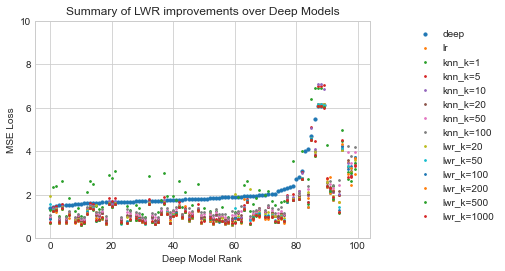

In [11]:
#take 1 is a scatter plot - lets, for each dataset
#graph our deep models by rank - plot - then overlay our knn moels
#plot points

deep_set = scores_df[scores_df["predictor"]=="deep"].sort_values("MSE")
deep_set["order"] = [i for i in range(0,100)]
deep_ordering = {row["model_num"]:row["order"] for index, row in deep_set.iterrows()}

def order_models(x):
    x = [deep_ordering[i] for i in x]
    return x

fig, ax = plt.subplots()
set_deep = False
knn_models = scores_df["predictor"].unique()
for knn_model in knn_models:
    subset = scores_df[scores_df["predictor"]==knn_model]
    s=3
    if knn_model == "deep":
        s=10
    ax.scatter(x=order_models(subset["model_num"].tolist()), y=subset["MSE"], s=s, label=knn_model)

#ax.set_ylim(0,scores_db["deep_mean"].max())
ax.set_ylim(0,10)
# plot residuals
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
ax.set_ylabel("MSE Loss")
ax.set_xlabel("Deep Model Rank")
#ax.set_yscale("symlog")
ax.set_title("Summary of LWR improvements over Deep Models")
plt.savefig(log_dir/f"summary_plot_mse.png", bbox_inches='tight')
logging.getLogger().info("Wrote Summary Graph")

Wrote Summary Graph'


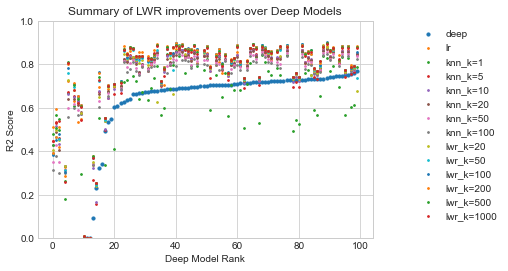

In [12]:
#take 1 is a scatter plot - lets, for each dataset
#graph our deep models by rank - plot - then overlay our knn moels
#plot points

deep_set = scores_df[scores_df["predictor"]=="deep"].sort_values("R2")
deep_set["order"] = [i for i in range(0,100)]
deep_ordering = {row["model_num"]:row["order"] for index, row in deep_set.iterrows()}

def order_models(x):
    x = [deep_ordering[i] for i in x]
    return x

fig, ax = plt.subplots()
set_deep = False
knn_models = scores_df["predictor"].unique()
for knn_model in knn_models:
    subset = scores_df[scores_df["predictor"]==knn_model]
    s=3
    if knn_model == "deep":
        s=10
    ax.scatter(x=order_models(subset["model_num"].tolist()), y=subset["R2"], s=s, label=knn_model)

#ax.set_ylim(0,scores_db["deep_mean"].max())
ax.set_ylim(0,1)
# plot residuals
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
ax.set_ylabel("R2 Score")
ax.set_xlabel("Deep Model Rank")
#ax.set_yscale("symlog")
ax.set_title("Summary of LWR improvements over Deep Models")
plt.savefig(log_dir/f"summary_plot_r2.png", bbox_inches='tight')
logging.getLogger().info("Wrote Summary Graph")